<center><span style="font-size:28px; font-weight:bold;">1 - Implementez un modèle de scoring</span><center>

<center><span style="font-size:28px; font-weight:bold;">Nettoyage et analyse exploratoire</span><center>

**Notebook réalisé par Gary MAUGER en Octobre 2024.**

Cette mission concerne l’entreprise....

https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

Utilisation de Ml Flow pour faire le tracking de ce notebook :

Étapes pour vous positionner dans le bon dossier

1. **Ouvrir un terminal.**

2. **Activer l'environnement Conda** :
   ```bash
   conda activate DataScientist_Projet_7
   ```

3. **Naviguer jusqu'au dossier du projet :**
   - Utiliser la commande `cd` pour vous déplacer dans le répertoire contenant le projet. Par exemple :
     ```bash
     cd /Users/Gary/Documents/GitHub/P7_implementer_modele_scoring
     ```

4. **Vérifier à être dans le bon dossier :**
   - Utiliser la commande `ls` (ou `dir` sur Windows) pour lister les fichiers dans le dossier et vous assurer que le répertoire `mlruns` est bien présent.
     ```bash
     ls
     ```
   - le dossier `mlruns` doit être parmi les fichiers listés.

5. **Lancez MLflow UI :**
   - Exécuter la commande suivante pour démarrer l'interface utilisateur de MLflow :
     ```bash
     mlflow ui
     ```

Une fois cela fait, vous pourrez accéder à l'interface utilisateur de MLflow via votre navigateur en visitant `http://127.0.0.1:5000`. 

Nous pouvons spécifier un autre port pour lancer l'interface utilisateur de MLflow. Par exemple, utiliser le port `5001` en lançant la commande suivante :

```bash
mlflow ui --port 5001
```

Ensuite, accéder à l'interface MLflow via le navigateur à l'adresse `http://127.0.0.1:5001`.

# 1 - Importation des librairies et des données

## 1.1 - Importation des différentes librairies

In [1]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time
import missingno as msno

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 - Importation des données

In [3]:
# Listons les fichiers à notre disposition
display(os.listdir("/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk"))

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [4]:
# Importation des données
df_application_train = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
df_application_test = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv')
df_bureau = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv')
df_credit_card_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv')
df_bureau_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv')
df_installments_payments = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv')
df_POS_CASH_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv')
df_previous_application = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv')

**Description du dataset provenant de Kaggle**

**Lien vers le dataset** : [https://www.kaggle.com/c/home-credit-default-risk/data](https://www.kaggle.com/c/home-credit-default-risk/data)

---

1. **application_{train|test}.csv**

   Il s'agit de la table principale, divisée en deux fichiers : un pour l'entraînement (avec la colonne TARGET) et un pour le test (sans la colonne TARGET). Données statiques pour toutes les demandes de prêt. Chaque ligne représente un prêt dans notre échantillon de données.

2. **bureau.csv**

   Tous les crédits précédents du client accordés par d'autres institutions financières et rapportés au Bureau de Crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait au Bureau de Crédit avant la date de la demande.

3. **bureau_balance.csv**

   Soldes mensuels des crédits précédents dans le Bureau de Crédit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Bureau de Crédit – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons un historique observable pour les crédits précédents) lignes.

4. **POS_CASH_balance.csv**

   Instantanés de solde mensuel des prêts précédents de point de vente (POS) et des prêts en espèces que le demandeur avait avec Home Credit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons un historique observable pour les crédits précédents) lignes.

5. **credit_card_balance.csv**

   Instantanés de solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois pour lesquels nous avons un historique observable pour la carte de crédit précédente) lignes.

6. **previous_application.csv**

   Toutes les demandes de prêt précédentes chez Home Credit des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

7. **installments_payments.csv**

   Historique des remboursements des crédits précédemment accordés chez Home Credit liés aux prêts dans notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'une échéance OU une échéance correspondant à un paiement d'un crédit Home Credit précédent lié aux prêts dans notre échantillon.

8. **HomeCredit_columns_description.csv**

   Ce fichier contient les descriptions des colonnes dans les différents fichiers de données.

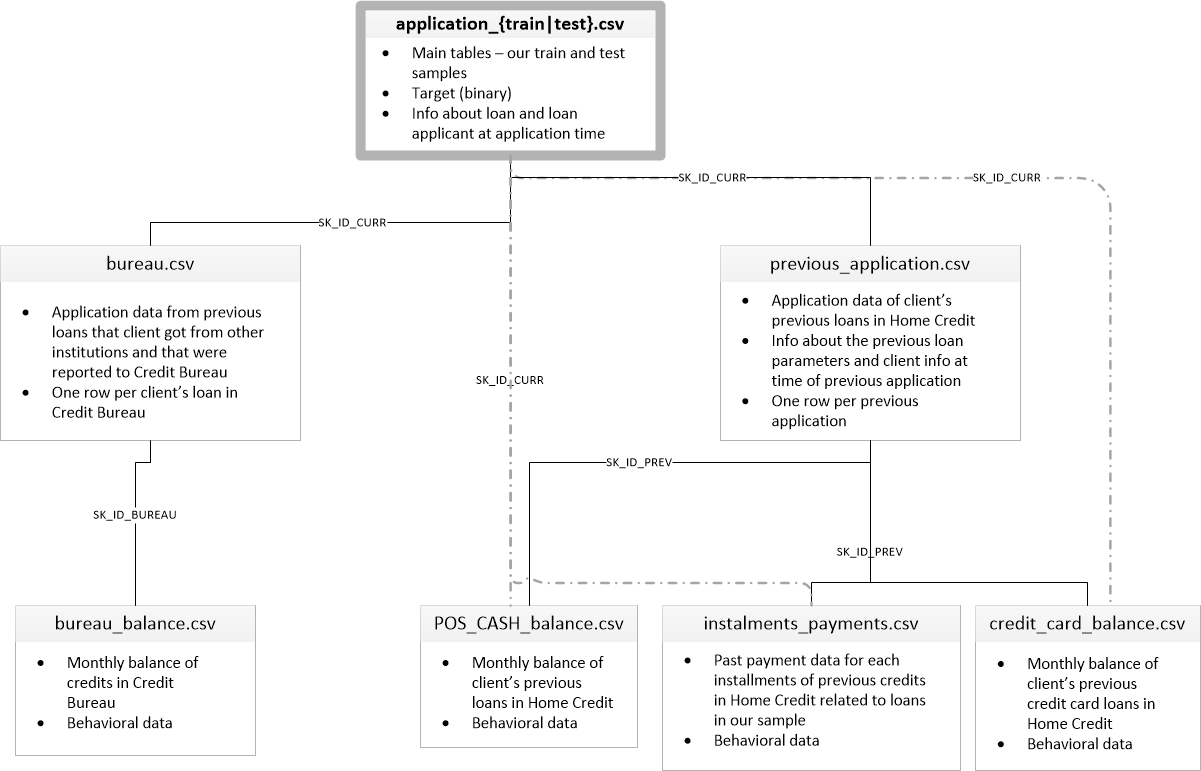

# 2 - Exploration initiale et nettoyage

In [5]:
# On va augmenter l'affichage du nombre de lignes et de colonnes 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [6]:
# Regardons la description de toutes nos variables
df_HomeCredit_columns_description = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
df_HomeCredit_columns_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [7]:
# Liste des DataFrames et leurs noms correspondants
dataframes = {
    'df_application_train': df_application_train,
    'df_application_test': df_application_test,
    'df_bureau': df_bureau,
    'df_bureau_balance': df_bureau_balance,
    'df_credit_card_balance': df_credit_card_balance,
    'df_installments_payments': df_installments_payments,
    'df_POS_CASH_balance': df_POS_CASH_balance,
    'df_previous_application': df_previous_application
}

# Fonction pour résumer un DataFrame
def summarize_df(df, name):
    rows = df.shape[0]
    columns = df.shape[1]
    nan_pct = (df.isnull().sum().sum() / (rows * columns)) * 100
    duplicate_pct = (df.duplicated().sum() / rows) * 100
    object_dtype = df.select_dtypes(include=['object']).shape[1]
    float_dtype = df.select_dtypes(include=['float64']).shape[1]
    int_dtype = df.select_dtypes(include=['int64']).shape[1]
    bool_dtype = df.select_dtypes(include=['bool']).shape[1]
    mb_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)  # Convertir en MB
    
    return {
        'DataFrame': name,
        'Rows': rows,
        'Columns': columns,
        '%NaN': round(nan_pct, 2),
        '%Duplicate': round(duplicate_pct, 2),
        'object_dtype': object_dtype,
        'float_dtype': float_dtype,
        'int_dtype': int_dtype,
        'bool_dtype': bool_dtype,
        'MB_Memory': round(mb_memory, 3)
    }

In [8]:
# Créer le résumé pour tous les DataFrames
summary = [summarize_df(df, name) for name, df in dataframes.items()]

# Convertir en DataFrame pour l'affichage
df_summary = pd.DataFrame(summary)
df_summary

,DataFrame,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
0,df_application_train,307511,122,24.40,0.0,16,65,41,0,536.692
1,df_application_test,48744,121,23.81,0.0,16,65,40,0,84.735
2,df_bureau,1716428,17,13.50,0.0,3,8,6,0,512.111
3,df_bureau_balance,27299925,3,0.00,0.0,1,0,2,0,1926.608
4,df_credit_card_balance,3840312,23,6.65,0.0,1,15,7,0,875.688
5,df_installments_payments,13605401,8,0.01,0.0,0,5,3,0,830.408
6,df_POS_CASH_balance,10001358,8,0.07,0.0,1,2,5,0,1137.250
7,df_previous_application,1670214,37,17.98,0.0,16,15,6,0,1900.632


1. **Taille des DataFrames**
   - **`df_application_train`** et **`df_application_test`** sont les plus petits en termes de lignes par rapport aux autres DataFrames, mais ils ont le plus grand nombre de colonnes.
   - **`df_bureau_balance`** est de loin le plus grand en termes de nombre de lignes (27 millions), ce qui est attendu pour un historique détaillé des crédits.

2. **Présence de Valeurs Manquantes (%NaN)**
   - Les valeurs manquantes sont assez élevées dans `df_application_train` (24.40%) et `df_application_test` (23.81%). Cela peut indiquer des données incomplètes ou nécessiter un nettoyage approfondi avant la modélisation.
   - Les autres DataFrames ont des pourcentages de valeurs manquantes beaucoup plus faibles, ce qui suggère que les données sont relativement complètes pour ces fichiers.

3. **Duplication des Données (%Duplicate)**
   - Aucun des DataFrames n’a de duplications dans les données (`%Duplicate` est 0.0 pour tous les DataFrames). Cela est bon signe et signifie que les données sont uniques au niveau des lignes.

4. **Types de Données**
   - **`df_application_train`** et **`df_application_test`** contiennent une grande proportion de colonnes d’objets (16), ce qui suggère qu'il y a beaucoup de variables catégorielles. Les autres DataFrames ont un nombre beaucoup plus faible de colonnes d’objets.
   - Les types de données numériques (`float_dtype` et `int_dtype`) sont relativement bien répartis entre les DataFrames, bien que certains DataFrames comme `df_credit_card_balance` et `df_installments_payments` aient une prépondérance de types `float`.

5. **Utilisation de la Mémoire (MB_Memory)**
   - **`df_bureau_balance`** utilise la plus grande quantité de mémoire (1926.608 MB), suivie de près par `df_previous_application` (1900.632 MB). Ces DataFrames ont un grand nombre de lignes, ce qui contribue à leur utilisation élevée de la mémoire.
   - Les DataFrames plus petits comme `df_application_test` et `df_application_train` consomment beaucoup moins de mémoire, ce qui est proportionnel à leur taille plus petite en termes de lignes et de colonnes.

## 2.1 - df_application_train/test

### 2.1.1 - Analyses univariées

In [9]:
# Informations sur df_application_train
df_application_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 536.7 MB


In [10]:
# df_application_train
print('Shape: ', df_application_train.shape)
df_application_train.head()

Shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
# Informations sur df_application_test
df_application_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 84.7 MB


In [12]:
# df_application_test
print('Shape: ', df_application_test.shape)
df_application_test.head()

Shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

<center><span style="font-size:18px; font-weight:bold;">Notre variable cible</span><center>

Il est important de bien comprendre la distribution de la variable cible (TARGET) car cela influencera les choix de modélisation et de traitement des données.

In [13]:
# Regardons la distribution de notre target
target_distribution = df_application_train['TARGET'].value_counts(normalize=True) * 100
print(target_distribution)
df_application_train['TARGET'].value_counts()

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


TARGET
0    282686
1     24825
Name: count, dtype: int64

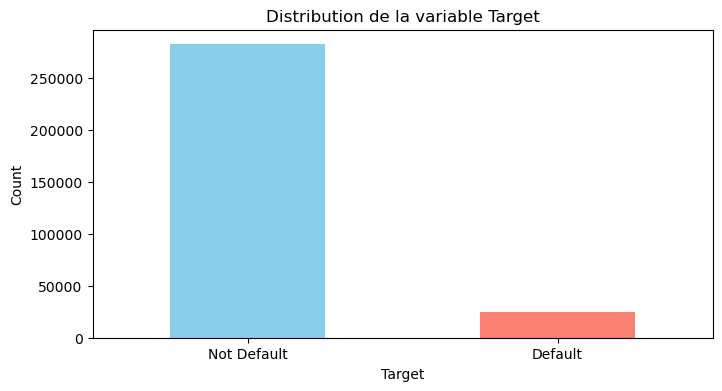

In [14]:
# Plot the target distribution
plt.figure(figsize=(8, 4))
df_application_train['TARGET'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution de la variable Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Default', 'Default'], rotation=0)
plt.show()

La distribution montre un déséquilibre entre les classes, avec une majorité d'échantillons dans la classe 0 (non défaillant) par rapport à la classe 1 (défaillant). Ce déséquilibre est assez fréquent dans les problèmes de classification, en particulier dans les cas de prédiction de défauts de crédit ou de fraude, où les événements de défaut sont généralement rares.


Le déséquilibre des classes peut affecter la performance du modèle de plusieurs façons :
- **Biais du Modèle** : Les modèles peuvent devenir biaisés vers la classe majoritaire (0 dans ce cas) et prédire principalement cette classe.
- **Évaluation du Modèle** : Les métriques classiques comme l'accuracy peuvent être trompeuses. Des métriques comme la précision, le rappel, la F-mesure, et la courbe ROC AUC sont souvent plus appropriées dans les cas de déséquilibre.


Pour traiter le déséquilibre des classes, nous pouvons utiliser plusieurs techniques :
- **Rééchantillonnage** : Utiliser des techniques de suréchantillonnage (par exemple, SMOTE) pour augmenter le nombre d'exemples de la classe minoritaire ou de sous-échantillonnage pour réduire le nombre d'exemples de la classe majoritaire.
- **Pondération des Classes** : Ajuster les poids des classes dans les algorithmes de classification pour donner plus d'importance à la classe minoritaire.
- **Modèles Spécifiques** : Utiliser des modèles conçus pour gérer les déséquilibres, comme les forêts d'arbres décisionnels équilibrées ou les algorithmes de boosting.

<center><span style="font-size:18px; font-weight:bold;">Type des colonnes</span><center>

In [15]:
# Nombre de colonnes de chaque type
df_application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

- **Colonnes de Type `float64` :** **65**
  - Ces colonnes contiennent des données numériques à virgule flottante. Elles sont souvent utilisées pour les caractéristiques continues.
  
- **Colonnes de Type `int64` :** **41**
  - Ces colonnes contiennent des données numériques entières. Elles peuvent représenter des comptages, des indicateurs binaires, ou d'autres valeurs discrètes.
  
- **Colonnes de Type `object` :** **16**
  - Ces colonnes contiennent des données de type chaîne de caractères (texte). Elles peuvent inclure des variables catégorielles ou des données textuelles qui doivent être converties en format numérique pour la modélisation.

**Implications pour l'Analyse et le Nettoyage**

- **Colonnes `float64` et `int64` :** 
  - Ces colonnes peuvent nécessiter un traitement pour gérer les valeurs manquantes, les valeurs aberrantes, et la normalisation ou la standardisation des données. 

- **Colonnes `object` :**
  - Les colonnes de type `object` doivent être converties en format numérique avant de pouvoir être utilisées dans les modèles de machine learning. Cela peut être fait par :
    - **Encodage des Catégories :** Utiliser des techniques d'encodage telles que l'encodage par étiquettes (`Label Encoding`) ou l'encodage one-hot (`One-Hot Encoding`) pour transformer les variables catégorielles en variables numériques.
    - **Gestion des Valeurs Manquantes :** Les colonnes de type `object` peuvent contenir des valeurs manquantes ou des catégories peu fréquentes.

<center><span style="font-size:18px; font-weight:bold;">Valeurs manquantes</span><center>

In [16]:
# Fonction qui va calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

L'analyse des valeurs manquantes est une étape importante dans le prétraitement des données, surtout lorsqu'il s'agit de préparer les données pour des modèles de machine learning. 

Pour les colonnes avec des pourcentages très élevés de valeurs manquantes :
- **Évaluer la Pertinence**: Déterminer si ces colonnes sont importantes pour notre analyse ou notre modèle. Si elles sont peu informatives ou redondantes, envisager de les supprimer.
- **Imputation ou Suppression**:
  - **Suppression**: Si une colonne a un pourcentage élevé de valeurs manquantes et n’est pas essentielle, nous pouvons la supprimer.
  - **Imputation**: Pour les colonnes essentielles, nous pouvons choisir une méthode d’imputation, comme la moyenne, la médiane, ou une méthode basée sur d’autres colonnes (comme la régression ou les techniques d’imputation avancées).

In [17]:
# Affichons les valeurs manquantes :
missing_values = missing_values_table(df_application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [18]:
# Affichons les valeurs manquantes :
missing_values_test = missing_values_table(df_application_test)
missing_values_test.head(20)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


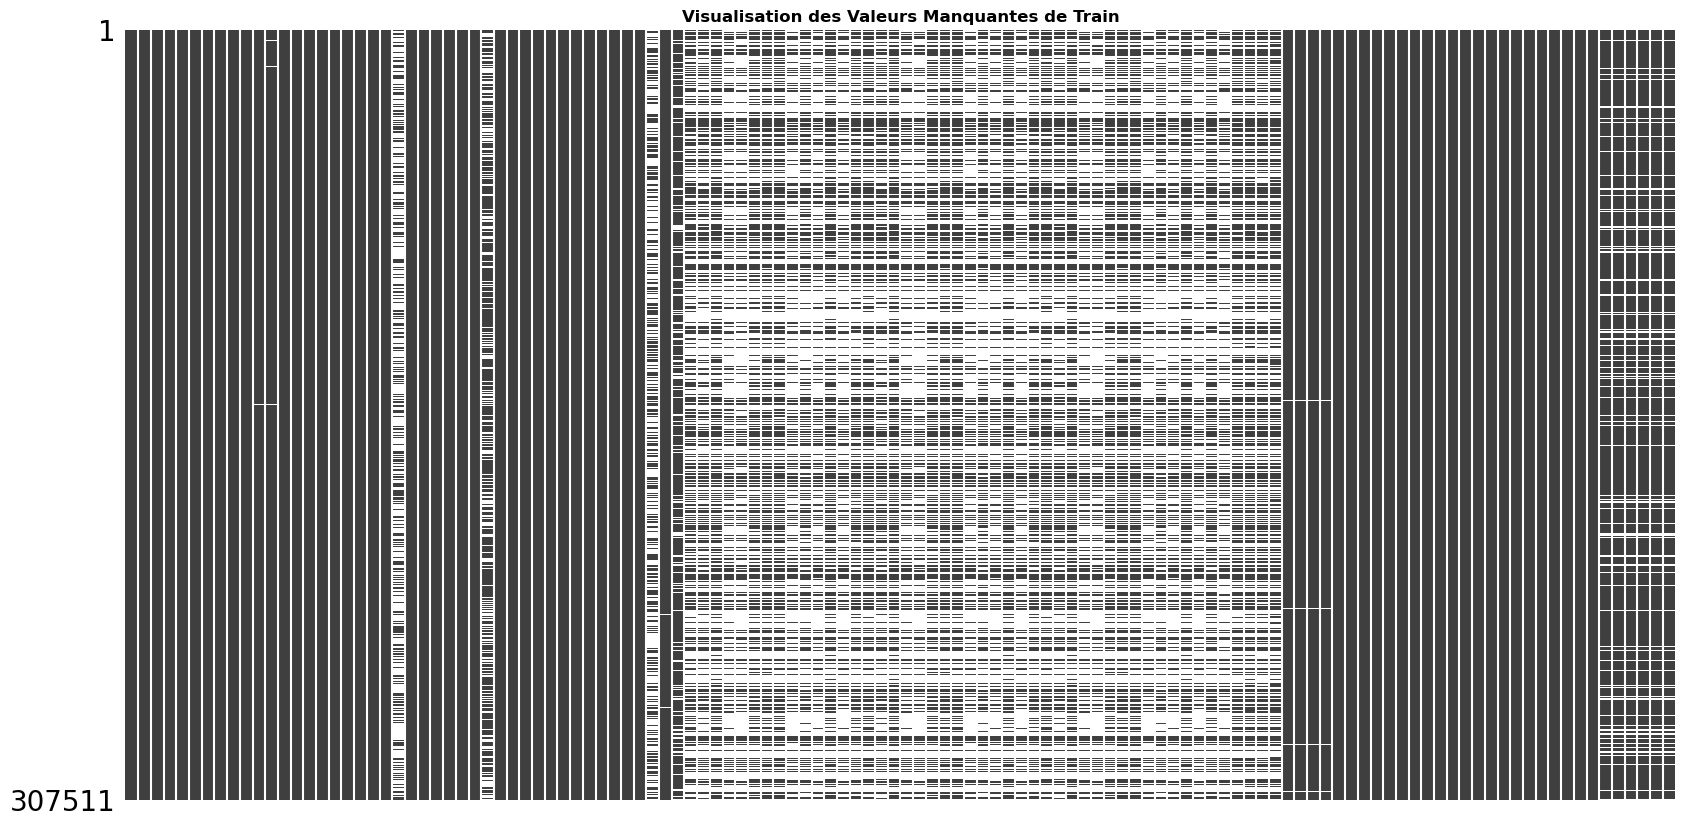

In [19]:
# Et on visualise les valeurs manquantes avec missingno :
msno.matrix(df_application_train, figsize=(20, 10), sparkline=False)
plt.title("Visualisation des Valeurs Manquantes de Train", fontsize=12, fontweight="bold")
plt.xticks(fontsize=8)
plt.show()

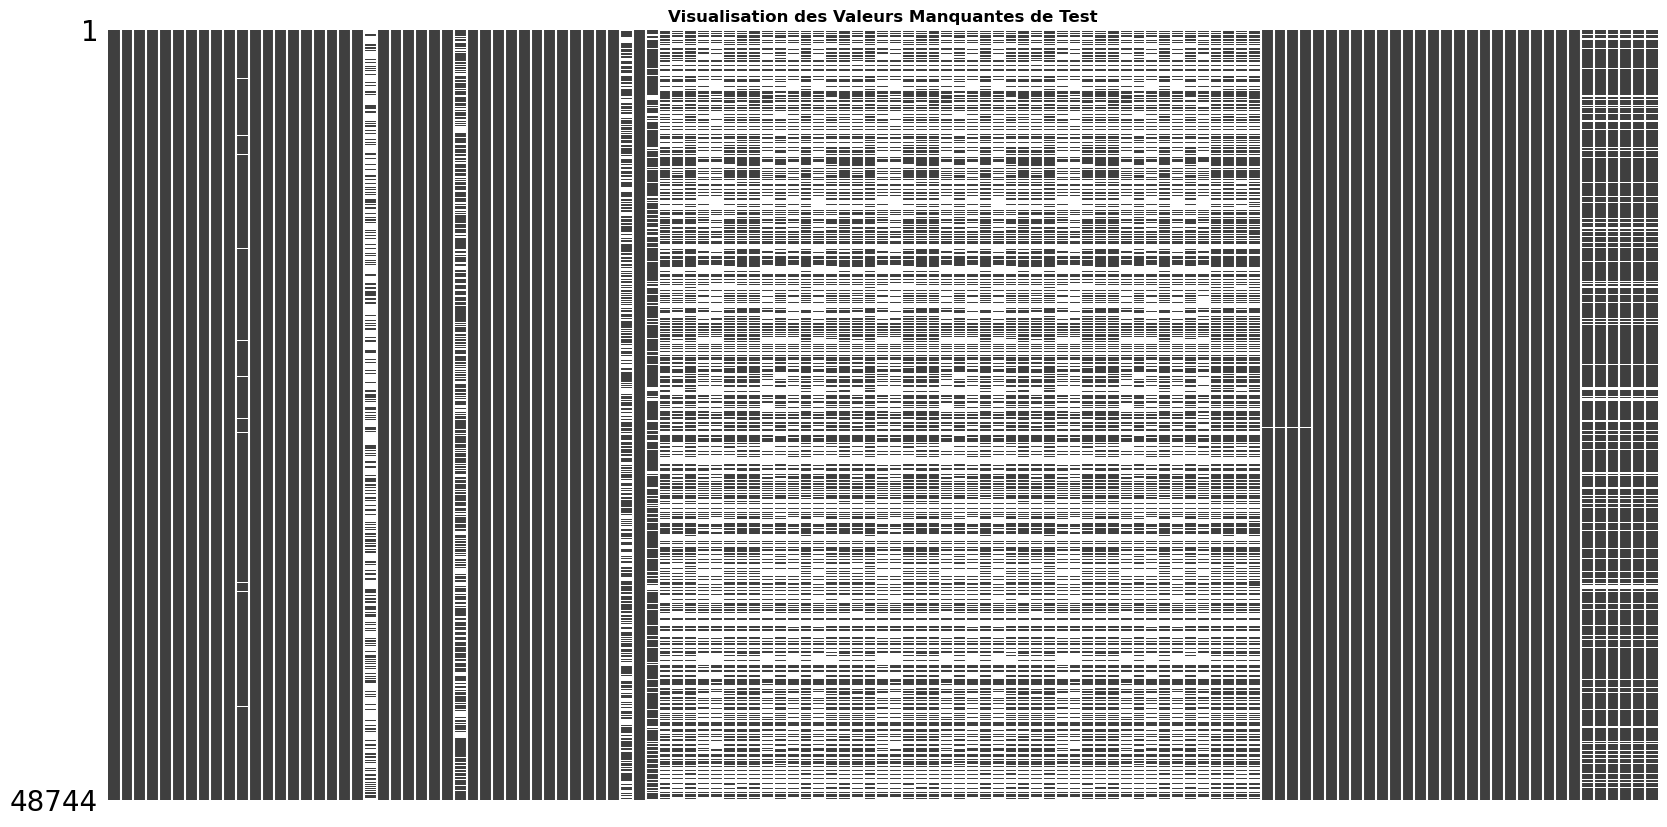

In [20]:
# Et on visualise les valeurs manquantes avec missingno :
msno.matrix(df_application_test, figsize=(20, 10), sparkline=False)
plt.title("Visualisation des Valeurs Manquantes de Test", fontsize=12, fontweight="bold")
plt.xticks(fontsize=8)
plt.show()

En modélisation, notamment avec des algorithmes comme XGBoost, il est souvent possible de gérer les valeurs manquantes directement, car ces modèles peuvent travailler avec des données incomplètes de manière plus robuste que certains autres types de modèles. 

1. **Distribution des Valeurs Manquantes**
   - **Colonnes Concernées**: Les valeurs manquantes sont principalement concentrées dans les caractéristiques liées aux habitats et non dans les variables liées aux crédits.
   - **TOP 20 des Colonnes avec Plus de NaN**: Les colonnes relatives aux caractéristiques des habitats (comme `COMMONAREA_MEDI`, `LIVINGAPARTMENTS_MODE`, etc.) présentent des taux très élevés de valeurs manquantes.

&nbsp;
2. **Implications pour le Modèle**
   - **Impact Potentiel**: Les caractéristiques avec des valeurs manquantes élevées peuvent influencer la qualité de la modélisation si elles sont importantes pour la prédiction. Cependant, les modèles comme XGBoost peuvent traiter les NaN nativement, ce qui simplifie la prétraitement des données.
   - **Évaluation de l'Importance**: Puisqu'on ne peut pas toujours anticiper l'importance de ces variables pour le modèle, il est prudent de ne pas les éliminer immédiatement sans analyse plus approfondie.

&nbsp;
3. **Analyse de l'Importance des Variables**
   - **Importance des Variables**: Nous allons utiliser des méthodes comme l’analyse de l'importance des variables (feature importance) après une première modélisation pour identifier quelles variables sont réellement pertinentes.

<center><span style="font-size:18px; font-weight:bold;">Valeurs uniques</span><center>

Analyser le nombre de valeurs uniques dans les colonnes catégorielles va nous aider à comprendre la diversité des catégories présentes dans notre dataset.

In [21]:
# Nombre de valeurs uniques pour les colonnes object
df_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

1. **Colonnes avec Peu de Catégories**
   - **`NAME_CONTRACT_TYPE`, `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `EMERGENCYSTATE_MODE`**:
     - Ces colonnes ont 2 valeurs uniques, ce qui indique qu’elles contiennent des variables binaires. Elles sont généralement simples à traiter car elles ne nécessitent pas une grande complexité pour la modélisation.

2. **Colonnes avec Modéré Nombre de Catégories**
   - **`NAME_TYPE_SUITE`, `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS`, `NAME_HOUSING_TYPE`, `WEEKDAY_APPR_PROCESS_START`, `FONDKAPREMONT_MODE`, `HOUSETYPE_MODE`, `WALLSMATERIAL_MODE`**:
     - Ces colonnes ont un nombre modéré de valeurs uniques (entre 3 et 18). Elles contiennent des variables catégorielles avec plusieurs options, ce qui peut nécessiter une transformation en variables numériques (par exemple, via l'encodage).

3. **Colonnes avec Nombre Élevé de Catégories**
   - **`OCCUPATION_TYPE`, `ORGANIZATION_TYPE`**:
     - Ces colonnes ont un grand nombre de valeurs uniques (respectivement 18 et 58). Elles représentent des variables avec une grande diversité de catégories, ce qui peut nécessiter des techniques spécifiques comme l'encodage par entités, ou l'utilisation de méthodes pour gérer le cardinalité élevée.

<center><span style="font-size:18px; font-weight:bold;">Encodage des variables catégorielles</span><center>

In [22]:
application_train = df_application_train.copy()
application_test = df_application_test.copy()

1. **Encodage des Variables Catégorielles**
   - **Variables Binaires**: Les colonnes avec 2 valeurs uniques peuvent être converties en variables binaires directement (0 ou 1).
   - **Variables avec Modéré Nombre de Catégories**: Nous pouvons utiliser l'encodage one-hot (ou dummies) pour ces variables. Cette méthode crée des colonnes supplémentaires pour chaque catégorie.
   - **Variables avec Nombre Élevé de Catégories**: Pour les variables avec un grand nombre de catégories, nous pouvons envisager l’encodage par entités ou le regroupement des catégories rares. L'encodage one-hot peut entraîner un très grand nombre de colonnes, ce qui peut ne pas être optimal.

2. **Gestion des Variables à Cardinalité Élevée**
   - **Réduction de Cardinalité**: Nous pouvons regrouper les catégories rares ou peu fréquentes sous une catégorie commune (par exemple, "Autre").
   - **Encodage par Entités**: Nous pouvons utiliser des techniques d'encodage basées sur les cibles (target encoding) ou des encodages fréquents pour ces colonnes.

Le code suivant sert à encoder les colonnes catégorielles avec un nombre de valeurs uniques inférieur ou égal à 2 en utilisant `LabelEncoder` de la bibliothèque `sklearn`.

Le `one-hot encoding` suivant va transformer nos variables catégorielles en colonnes binaires pour chaque valeur unique.

Il y a une différence dans le nombre de colonnes entre les ensembles de données d'entraînement et de test :
- **Entraînement**: 243 colonnes
- **Test**: 239 colonnes

Cette différence de colonnes est souvent due à des catégories présentes dans l'ensemble d'entraînement mais absentes dans l'ensemble de test (ou vice versa). Cela peut poser problème pour les modèles, car chaque ensemble de données doit avoir les mêmes colonnes pour que la modélisation soit cohérente.

Nous pouvons résoudre ce problème en garantissant que les deux ensembles de données (entraînement et test) ont les mêmes colonnes après `one-hot encoding`.

<center><span style="font-size:18px; font-weight:bold;">Gestion des anomalies</span><center>

Un problème auquel nous devons toujours être attentifs lors de l'exploration des données est la détection des anomalies. Celles-ci peuvent être dues à des erreurs de saisie, des problèmes avec les équipements de mesure, ou bien elles peuvent représenter des mesures valides mais extrêmes. Une façon de détecter quantitativement les anomalies est d'examiner les statistiques d'une colonne en utilisant la méthode `describe`."

In [23]:
# Cherchons des anomalies pour nos variables integer
df_application_train.select_dtypes('int64').describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0000

In [24]:
# Cherchons des anomalies pour nos variables float
df_application_train.select_dtypes('float64').describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,0.081184,0.092576,0.110565,0.047732,0.069523,0.107936,0.084307,0.064575,0.110111,0.074445,0.132256,0.100977,0.143709,0.161160,0.081750,0.097880,0.111845,0.046276,0.070254,0.109076,0.082179,0.059897,0.112066,0.076144,0.134467,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.3

In [25]:
# Regardons notre variable DAYS_BIRTH
df_application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [26]:
# Nous pouvons voir ces stats en années
(df_application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

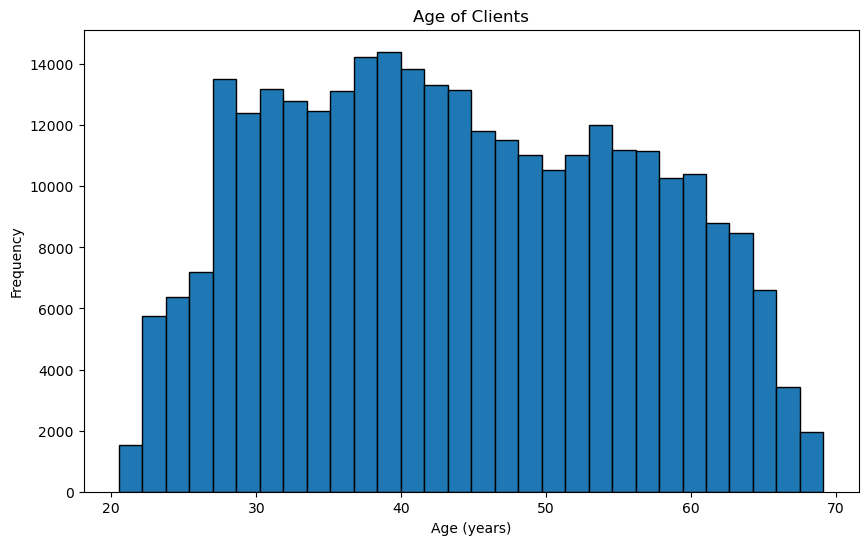

In [27]:
# Convertissons DAYS_BIRTH en âge en années
df_application_train['AGE'] = -df_application_train['DAYS_BIRTH'] / 365

# Créons l'histogramme
plt.figure(figsize=(10, 6))
df_application_train['AGE'].plot.hist(bins=30, edgecolor='black')
plt.title('Age of Clients')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

1. `DAYS_BIRTH`

- **Moyenne (`mean`)**: -16037 jours, soit environ 43,9 ans.
- **Minimum (`min`)**: -25229 jours, soit environ 69,1 ans.
- **Maximum (`max`)**: -7489 jours, soit environ 20,5 ans.

La colonne `DAYS_BIRTH` représente l'âge des clients en jours avant la date de l'enregistrement. Les valeurs sont négatives, car elles sont comptées à rebours à partir de la date de l'enregistrement.

- **Âge minimum** : La valeur minimale de -25229 jours correspond à environ 69,1 ans. Cela semble réaliste pour une base de données de clients d'une institution financière.
- **Âge maximum** : La valeur maximale de -7489 jours correspond à environ 20,5 ans, ce qui pourrait indiquer que des personnes assez jeunes (potentiellement début de carrière) sont également présentes dans cette base de données.

Les valeurs semblent toutes plausibles et aucune anomalie évidente n'est observée ici. Qu'en est-il de la durée des contrats de travail ?

In [28]:
# Age information into a separate dataframe
age_data = df_application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"
5,0,-16941,46.413699,"(45.0, 50.0]"
6,0,-13778,37.747945,"(35.0, 40.0]"
7,0,-18850,51.643836,"(50.0, 55.0]"
8,0,-20099,55.065753,"(55.0, 60.0]"
9,0,-14469,39.641096,"(35.0, 40.0]"


In [29]:
# Regardons notre variable DAYS_EMPLOYED
df_application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

2. `DAYS_EMPLOYED`

- **Moyenne (`mean`)**: 63815 jours, ce qui est clairement anormal et indique la présence d'une anomalie.
- **Minimum (`min`)**: -17912 jours, soit environ 49 ans d'emploi.
- **Maximum (`max`)**: 365243 jours, soit environ 1000 ans d'emploi, ce qui est impossible.

La colonne `DAYS_EMPLOYED` représente le nombre de jours pendant lesquels le client a été employé. Les valeurs positives indiquent une anomalie évidente.

- **Anomalie majeure** : La valeur maximale de 365243 jours est irréaliste (environ 1000 ans d'emploi). Cette valeur est probablement utilisée comme un code pour représenter des valeurs manquantes ou des cas particuliers où les informations d'emploi ne sont pas disponibles.
- **Valeurs négatives** : Les valeurs négatives semblent logiques, car elles indiquent le nombre de jours depuis le début de l'emploi jusqu'à la date de l'enregistrement, avec des valeurs correspondant à des périodes d'emploi réalistes.

Par curiosité, examinons un sous-ensemble des clients présentant ces anomalies pour voir s'ils ont tendance à avoir des taux de défaut plus élevés ou plus bas que le reste des clients.

In [30]:
anom = df_application_train[df_application_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_application_train[df_application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


1. **Taux de défaut pour les non-anomalies :**  
   - Les clients sans anomalies dans `DAYS_EMPLOYED` (c'est-à-dire ceux pour lesquels les jours d'emploi ne sont pas égaux à 365243) ont un taux de défaut de **8,66%**.
  
2. **Taux de défaut pour les anomalies :**  
   - Les clients avec l'anomalie (DAYS_EMPLOYED = 365243) ont un taux de défaut de **5,40%**.
  
3. **Nombre d'anomalies détectées :**  
   - Il y a **55 374** clients avec des valeurs anormales dans `DAYS_EMPLOYED`.

**Interprétation**

- **Taux de défaut inférieur pour les anomalies :**
  - Étonnamment, les clients avec l'anomalie `DAYS_EMPLOYED` semblent avoir un taux de défaut inférieur (5,40%) par rapport aux autres clients (8,66%). 
  - Cela pourrait indiquer que ces anomalies sont associées à un sous-ensemble spécifique de clients, potentiellement des retraités, des personnes sans emploi mais ayant d'autres formes de revenu stables, ou des cas particuliers où l'emploi n'est pas la principale source de revenus.
  
- **Implications pour le modèle :**
  - **Prise en compte des anomalies :** Cette différence de comportement suggère que ces anomalies ne devraient pas simplement être ignorées, mais plutôt traitées comme une catégorie spéciale dans la modélisation. Par exemple, nous pourrions ajouter une variable binaire (comme `DAYS_EMPLOYED_ANOM`) pour indiquer la présence de cette anomalie.
  - **Stratégies de modélisation :** Le fait que ces clients aient un taux de défaut inférieur pourrait influencer la performance de certains modèles si cette information n'est pas correctement intégrée.

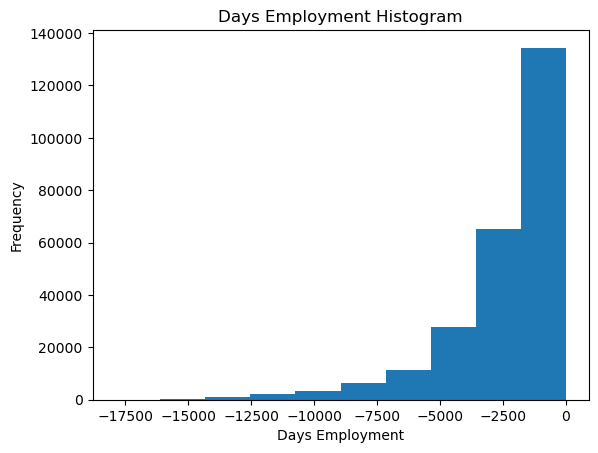

In [31]:
# Créons une variable DAYS_EMPLOYED_ANOM
df_application_train['DAYS_EMPLOYED_ANOM'] = df_application_train["DAYS_EMPLOYED"] == 365243

# Remplaçons les anomalies par des nan
df_application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

La distribution semble désormais beaucoup plus conforme à ce que nous attendions, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine des anomalies (car nous devrons remplir les valeurs manquantes avec une valeur, probablement la médiane de la colonne). Les autres colonnes contenant des données en jours dans le dataframe semblent être conformes à nos attentes, sans valeurs aberrantes évidentes.

Il est extrêmement important de noter que tout ce que nous faisons aux données d'entraînement doit également être fait aux données de test. Assurons-nous donc de créer la nouvelle colonne et de remplir la colonne existante avec np.nan dans les données de test également.

In [32]:
# Faisons de même pour les données de test
df_application_test['DAYS_EMPLOYED_ANOM'] = df_application_test["DAYS_EMPLOYED"] == 365243
df_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_test)))

There are 9274 anomalies in the test data out of 48744 entries


<center><span style="font-size:18px; font-weight:bold;">Distribution des différents types de contrats</span><center>

Nous allons afficher un premier graphique montrant la distribution des types de contrats (NAME_CONTRACT_TYPE) et un second graphique indiquant le pourcentage de défaut de paiement pour chaque type de contrat.

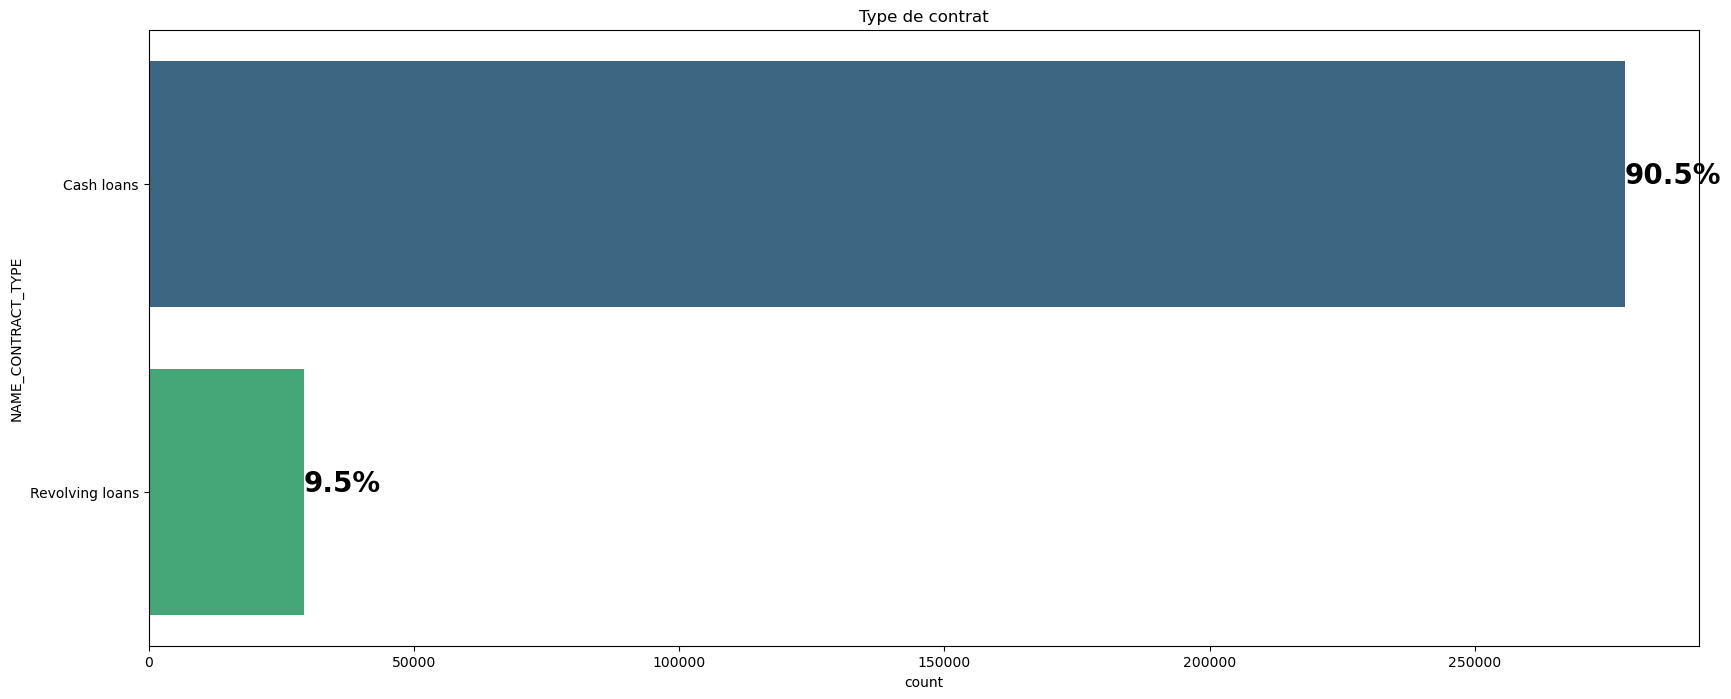

In [33]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_CONTRACT_TYPE'
title = 'Type de contrat'

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=application_train, order=application_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(application_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

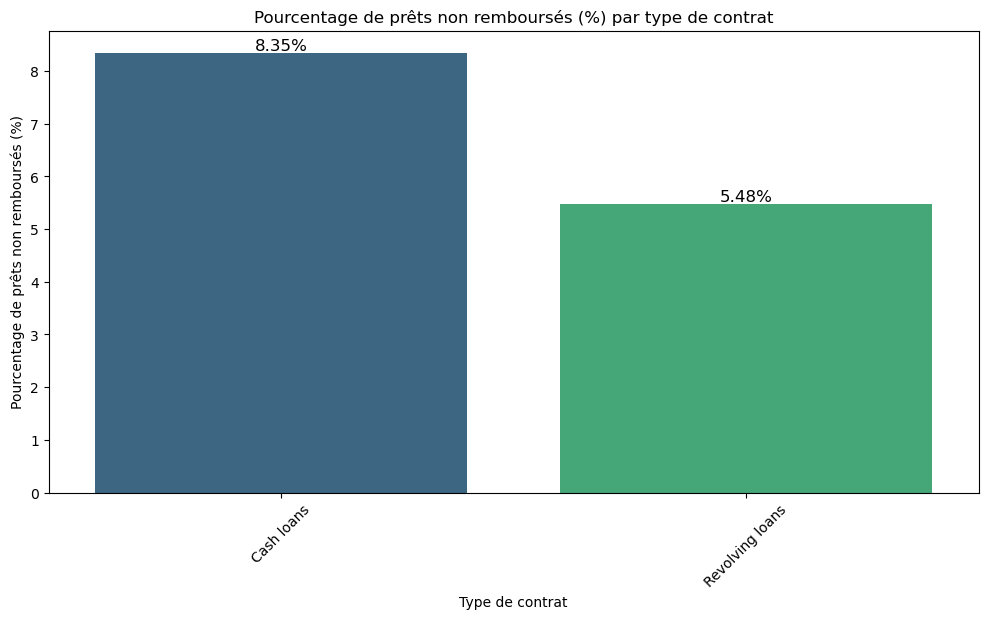

In [34]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = application_train.groupby('NAME_CONTRACT_TYPE')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("Pourcentage de prêts non remboursés (%) par type de contrat")
plt.xlabel('Type de contrat')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

Les prêts renouvelables sont un type de crédit qui permet à l'emprunteur de réutiliser les fonds au fur et à mesure qu'ils sont remboursés, contrairement aux autres prêts, qui ont un montant fixe et une durée fixe.

Les prêts renouvelables représentent environ **10%** du nombre total de prêts dans notre ensemble de données. Malgré leur faible fréquence, les prêts renouvelables montrent une tendance à être **moins souvent remboursés** que les autres types de prêts. Cela pourrait indiquer que ce type de crédit est plus risqué pour les prêteurs, car les emprunteurs ont plus de flexibilité dans leur utilisation, ce qui peut conduire à une gestion moins stricte des finances et donc à des taux de défaut plus élevés.

**Contexte possible**
Les prêts renouvelables sont souvent utilisés par des emprunteurs qui ont besoin de flexibilité financière ou qui peuvent avoir des besoins de crédit récurrents. Cependant, cette flexibilité peut aussi entraîner une utilisation excessive ou des difficultés à gérer les remboursements, surtout si les taux d'intérêt sont élevés.
Les prêteurs doivent évaluer soigneusement le risque associé aux prêts renouvelables. Le fait que ces prêts soient moins souvent remboursés suggère qu'ils pourraient nécessiter des critères de sélection plus stricts ou des taux d'intérêt plus élevés pour compenser le risque.

<center><span style="font-size:18px; font-weight:bold;">Genre des clients</span><center>

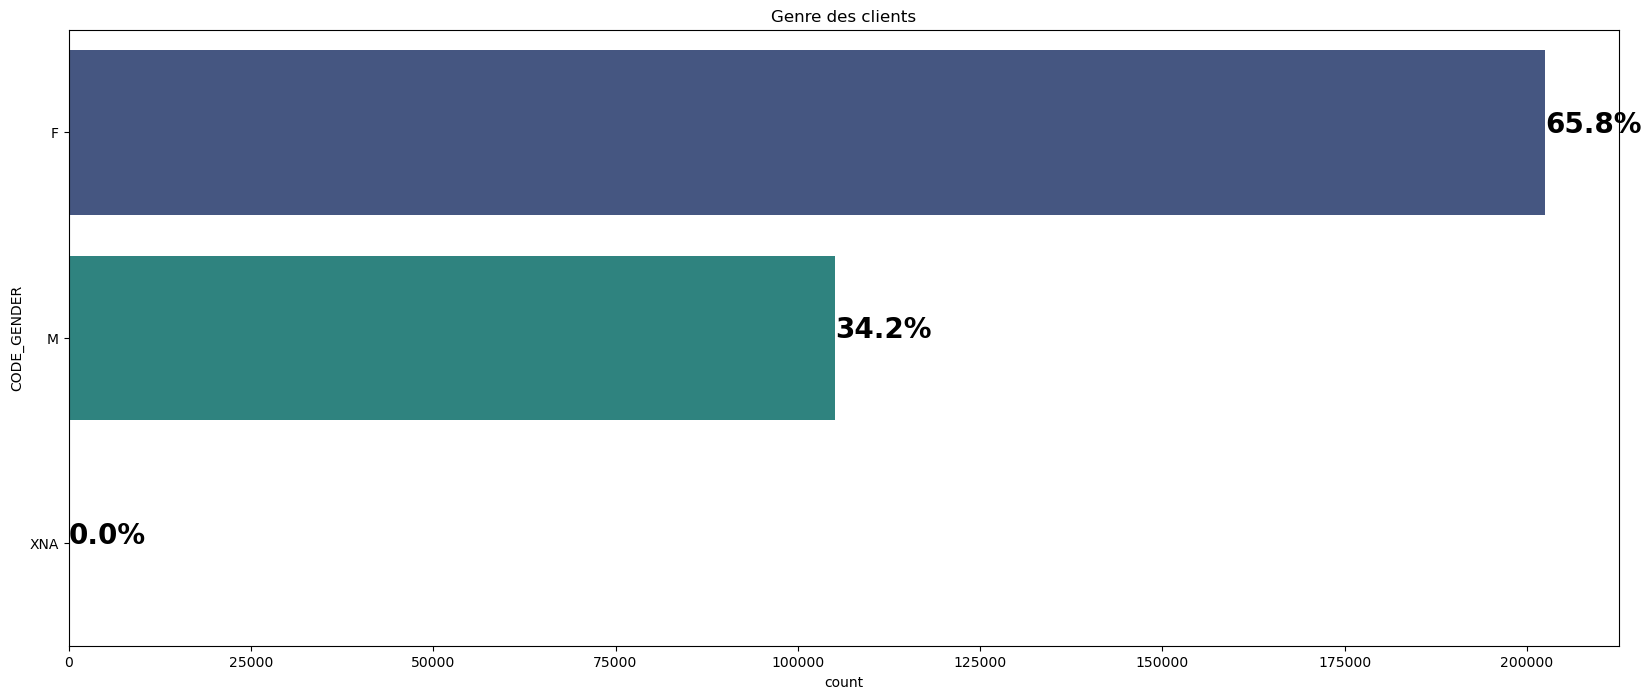

In [35]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'CODE_GENDER'
title = 'Genre des clients'

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=application_train, order=application_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(application_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

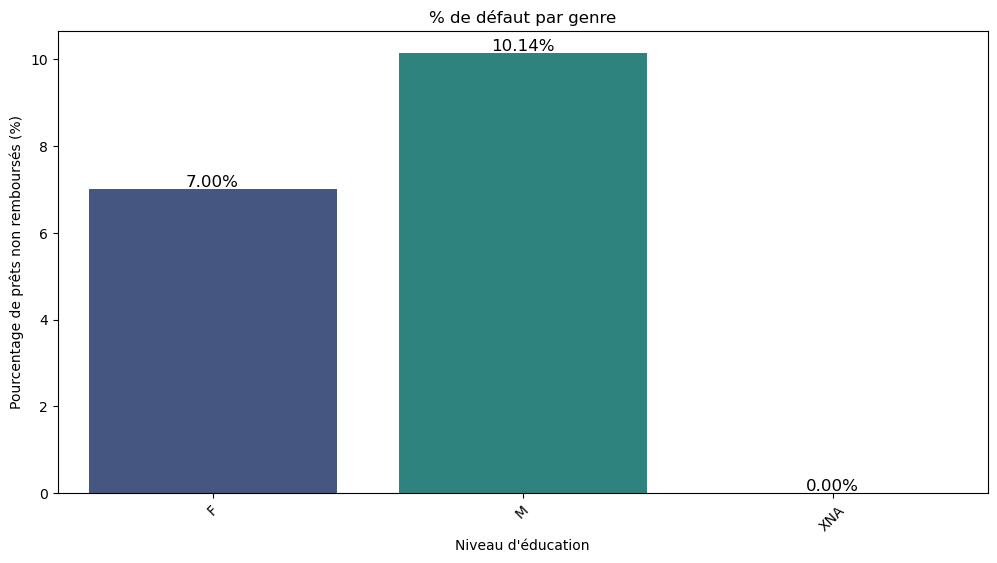

In [36]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = application_train.groupby('CODE_GENDER')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("% de défaut par genre")
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

On peut observer que le nombre de clients féminins est nettement supérieur à celui des clients masculins. Ce déséquilibre dans la distribution des genres peut être significatif lorsqu'on examine les comportements financiers.

En ce qui concerne le pourcentage de crédits non remboursés, les hommes semblent présenter un risque plus élevé, avec un taux de défaut de 10% comparé à 7% pour les femmes. Cela indique que, bien que les femmes soient plus nombreuses dans l'ensemble des clients, les hommes ont une probabilité plus élevée de rencontrer des difficultés pour rembourser leurs prêts.

<center><span style="font-size:18px; font-weight:bold;">Education des clients</span><center>

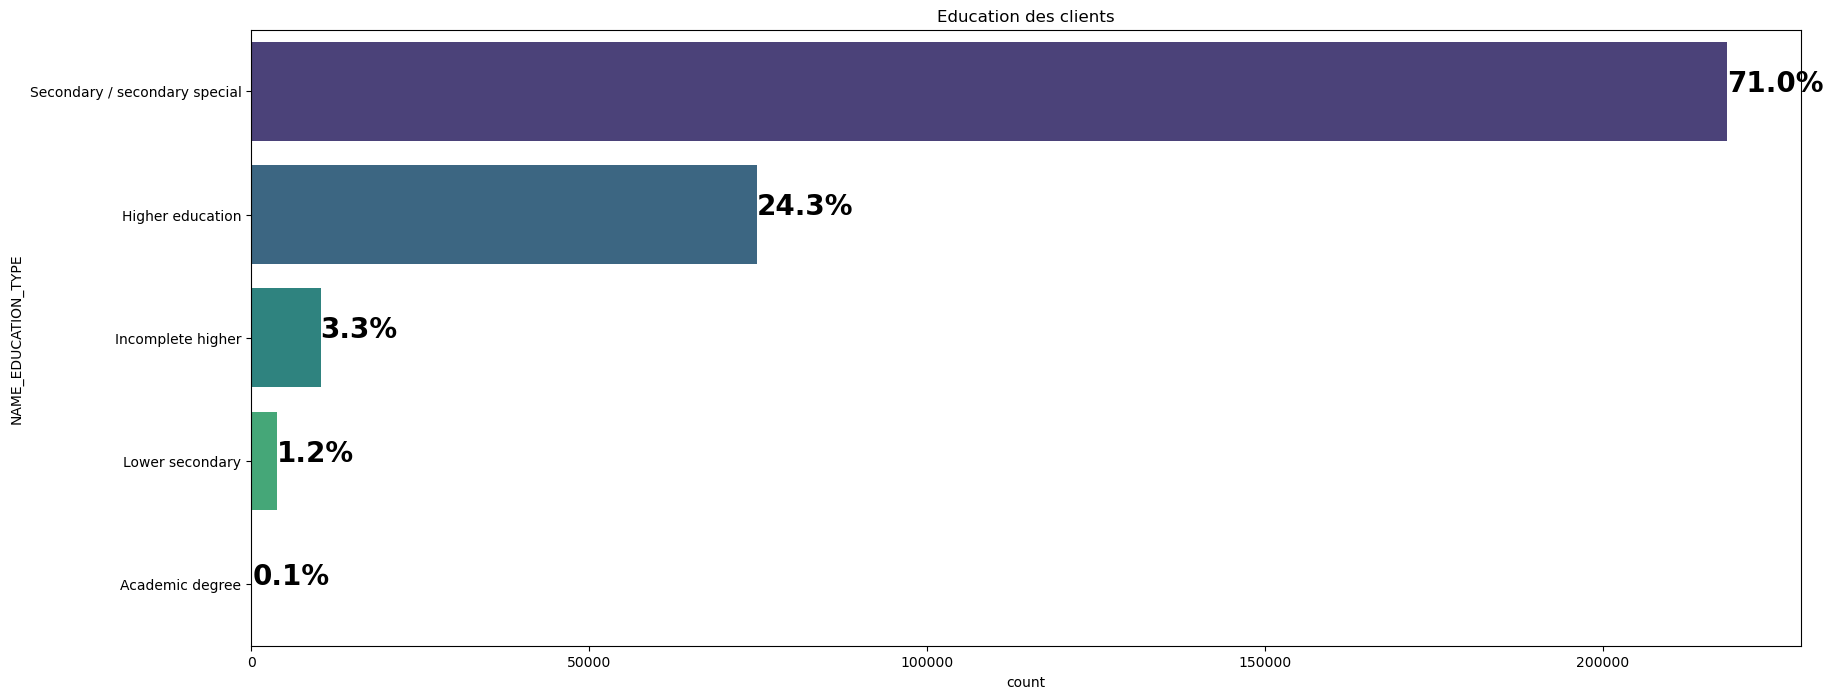

In [37]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_EDUCATION_TYPE'
title = 'Education des clients'

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=application_train, order=application_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(application_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

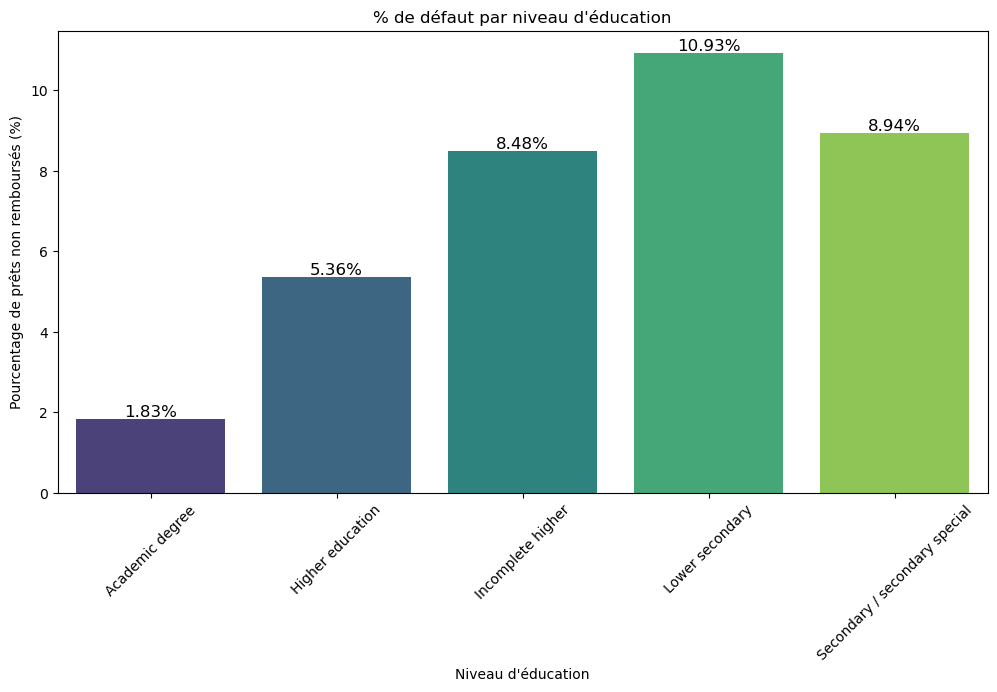

In [38]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = application_train.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("% de défaut par niveau d'éducation")
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

L'analyse montre une répartition inégale des niveaux d'éducation parmi les emprunteurs, avec une nette prédominance de ceux ayant une éducation secondaire. 

- **Secondaire/Supérieur** : La majorité des emprunteurs ont un niveau d'éducation secondaire, suivi par ceux ayant une éducation supérieure.
- **Diplôme universitaire** : Un très petit nombre d'emprunteurs ont un diplôme universitaire.

**Taux de non-remboursement par niveau d'éducation :**
   - **Premier cycle du secondaire** : Cette catégorie, bien que peu représentée, affiche le taux de non-remboursement le plus élevé, atteignant environ 11%.
   - **Diplôme universitaire** : Les emprunteurs ayant un diplôme universitaire présentent un risque de non-remboursement beaucoup plus faible, inférieur à 2%.

<center><span style="font-size:18px; font-weight:bold;">Type de logement des clients</span><center>

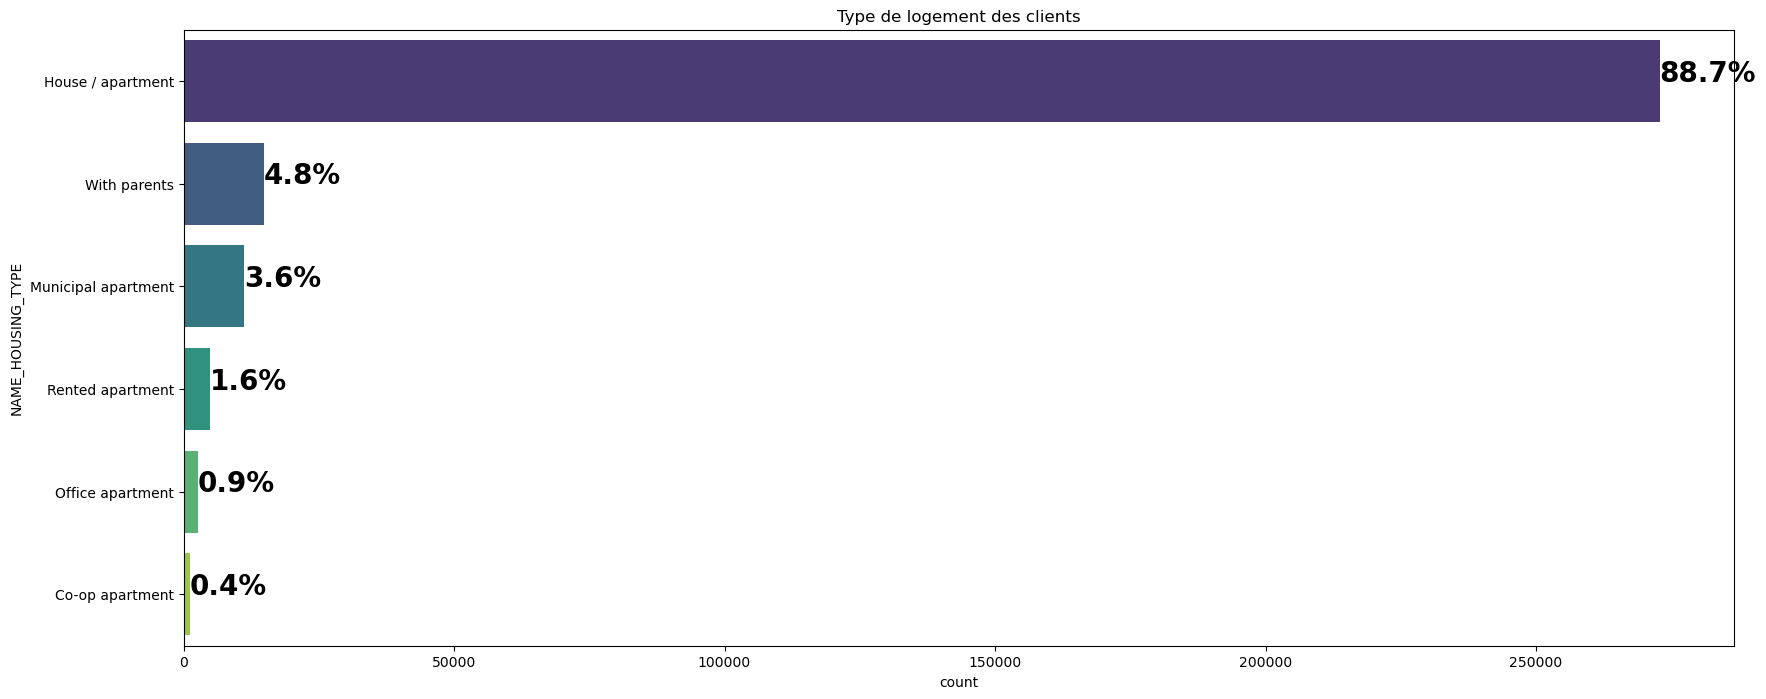

In [39]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_HOUSING_TYPE'
title = 'Type de logement des clients'

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=application_train, order=application_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(application_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

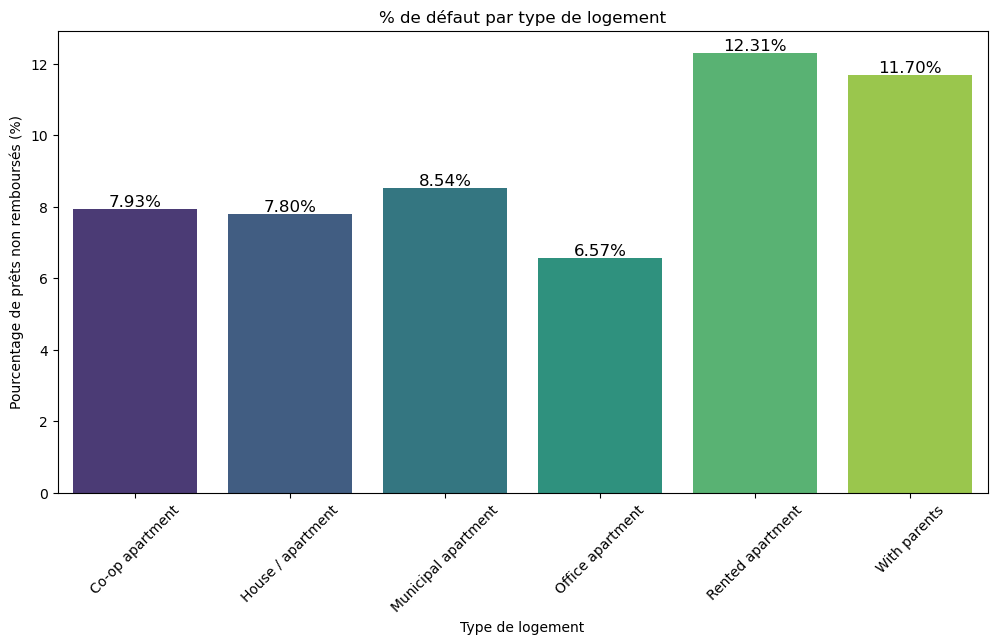

In [40]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = application_train.groupby('NAME_HOUSING_TYPE')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("% de défaut par type de logement")
plt.xlabel('Type de logement')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

**Distribution des types de logement**
- **Maison/Appartement** : Plus de 250 000 clients vivent dans leur propre maison ou appartement. C'est la catégorie la plus représentée.
- **Autres types de logement** : Les autres catégories, comme ceux qui vivent avec leurs parents ou dans des logements municipaux, représentent une proportion beaucoup plus faible de la population totale. Ces catégories sont souvent associées à une population moins indépendante.

**Taux de non-remboursement par type de logement**
- **Locataires d'appartements** : Ceux qui louent leur appartement (sans en être propriétaires) affichent un taux de non-remboursement supérieur à 10%. Cela pourrait indiquer une vulnérabilité économique ou un risque de crédit plus élevé pour cette catégorie.
- **Vivre chez ses parents** : De même, les clients vivant chez leurs parents montrent également un taux de non-remboursement supérieur à 10%. Cela peut refléter une moindre stabilité financière ou une moindre indépendance économique.

<center><span style="font-size:18px; font-weight:bold;">Type de revenu des clients</span><center>

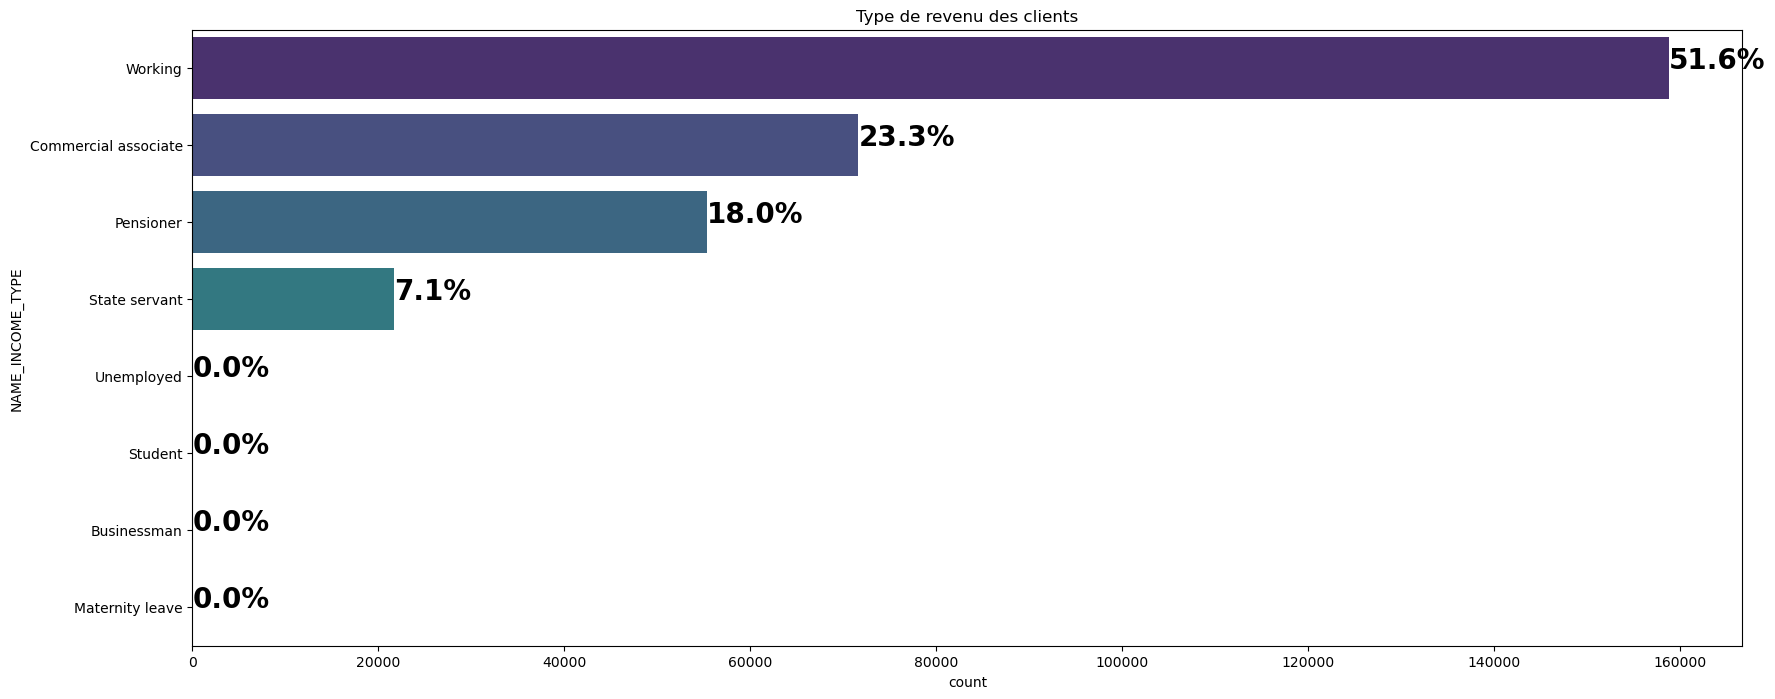

In [41]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_INCOME_TYPE'
title = 'Type de revenu des clients'

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=application_train, order=application_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(application_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

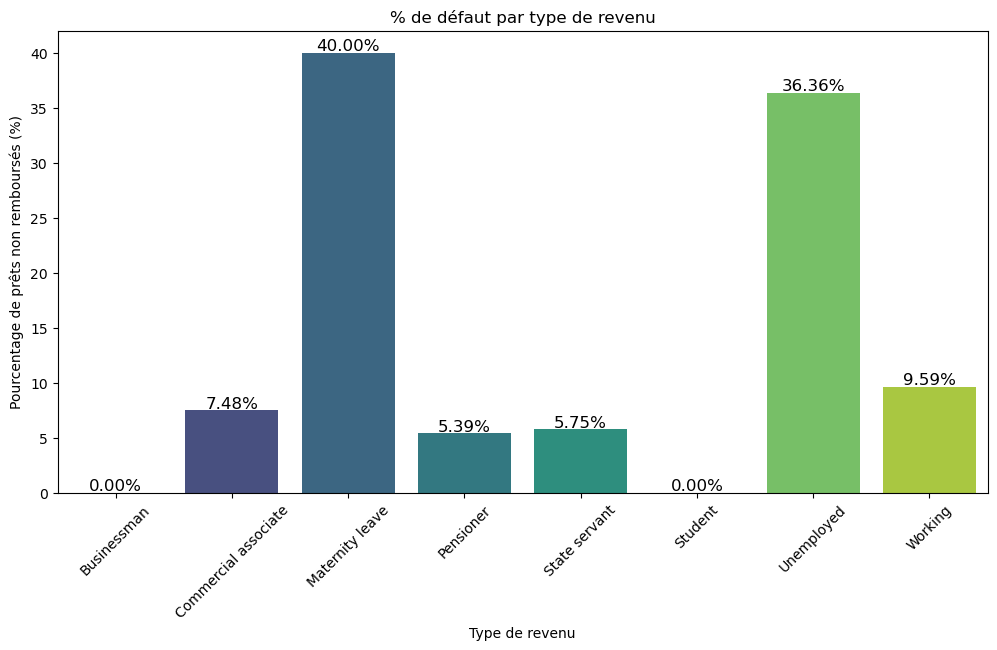

In [42]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = application_train.groupby('NAME_INCOME_TYPE')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("% de défaut par type de revenu")
plt.xlabel('Type de revenu')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

- **Revenus du travail** : La majorité des demandeurs de prêts appartiennent à cette catégorie, ce qui est attendu, car cette population constitue généralement la base principale des clients des institutions financières.
- **Associés commerciaux, retraités et fonctionnaires** : Ces catégories suivent les revenus du travail, représentant également une part importante des demandeurs de prêts.

**Taux de défault par type de revenu**
- **Congé de maternité** : Les demandeurs dans cette catégorie présentent un taux de non-remboursement particulièrement élevé, proche de 40%. Ce groupe pourrait être particulièrement vulnérable en raison de l'absence temporaire de revenu ou de la dépendance à une seule source de revenu dans un ménage.
- **Chômeurs** : Avec un taux de non-remboursement de 37%, cette catégorie est également à haut risque. Les chômeurs sont naturellement plus susceptibles de faire défaut en raison de l'instabilité financière.
- **Autres types de revenus** : Les catégories restantes, qui incluent principalement les travailleurs, les retraités, et les fonctionnaires, affichent des taux de défault inférieurs à 10%, ce qui est en dessous de la moyenne générale, et donc considérés comme des groupes à faible risque.

<center><span style="font-size:18px; font-weight:bold;">Statut familial des clients</span><center>

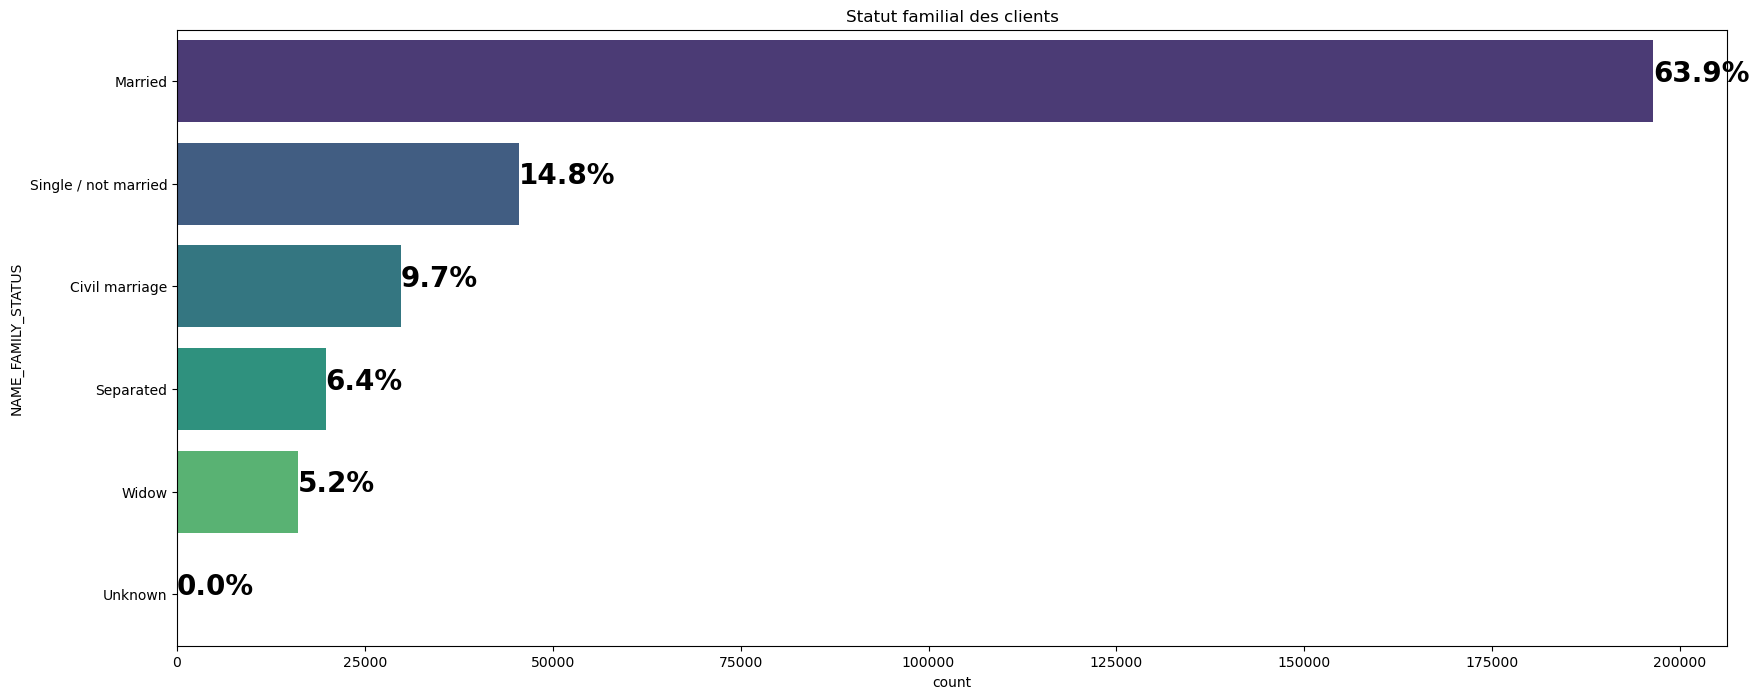

In [43]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_FAMILY_STATUS'
title = 'Statut familial des clients'

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=application_train, order=application_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(application_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

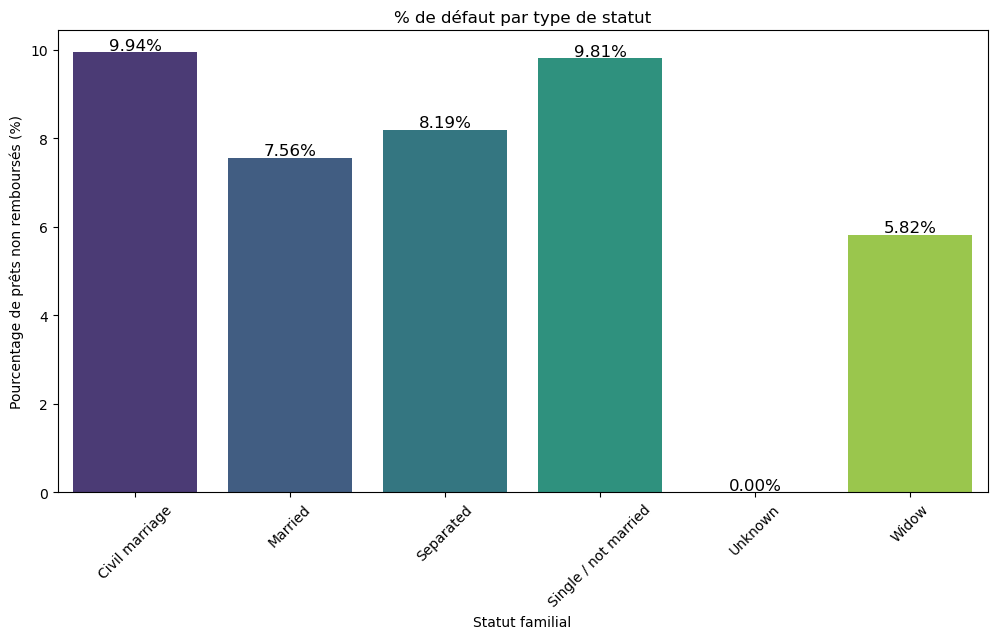

In [44]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = application_train.groupby('NAME_FAMILY_STATUS')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("% de défaut par type de statut")
plt.xlabel('Statut familial')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

- **Mariés** : La majorité des demandeurs de prêts sont des personnes mariées. Cela reflète souvent la stabilité financière que procure un double revenu au sein d'un ménage, ce qui les rend plus susceptibles de recevoir un crédit.
- **Célibataires / Non mariés** : Cette catégorie représente le deuxième plus grand groupe de clients. Les personnes non mariées peuvent parfois avoir moins de stabilité financière comparé aux couples mariés, bien que cela varie considérablement en fonction des circonstances individuelles.
- **Mariage civil** : Ce groupe représente également une part importante des clients.

**Taux de défault par statut familial**
- **Mariage civil** : Ce groupe présente le pourcentage le plus élevé de défault, avec environ 10% de défault.
- **Veuves** : Ce groupe a le taux de défault le plus bas, ce qui peut s'expliquer par une gestion prudente des finances en l'absence de soutien conjoint ou par la disponibilité de pensions ou d'autres formes de soutien financier.
- **Célibataires / Non mariés** : Bien que les célibataires soient souvent perçus comme présentant un risque plus élevé que les personnes mariées, leur taux de défault reste inférieur à celui des personnes en mariage civil, mais légèrement plus élevé que celui des personnes mariées.
- **Statut inconnu** : Ce groupe, bien qu'il soit minoritaire, présente également un faible taux de défault, ce qui peut être dû à une petite taille d'échantillon ou à d'autres facteurs non spécifiés.

<center><span style="font-size:18px; font-weight:bold;">Clients propriétaire de voiture</span><center>

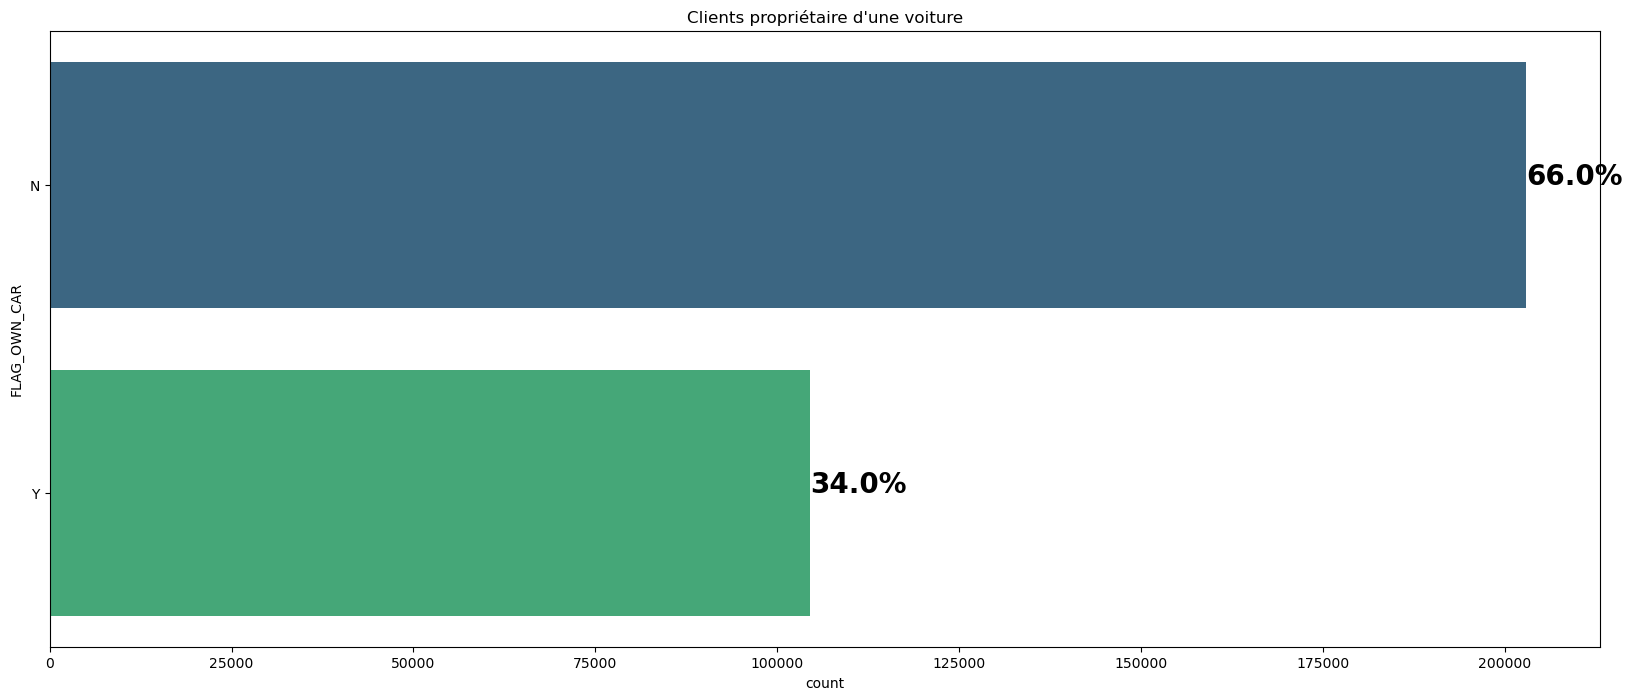

In [45]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'FLAG_OWN_CAR'
title = "Clients propriétaire d'une voiture"

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=application_train, order=application_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(application_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

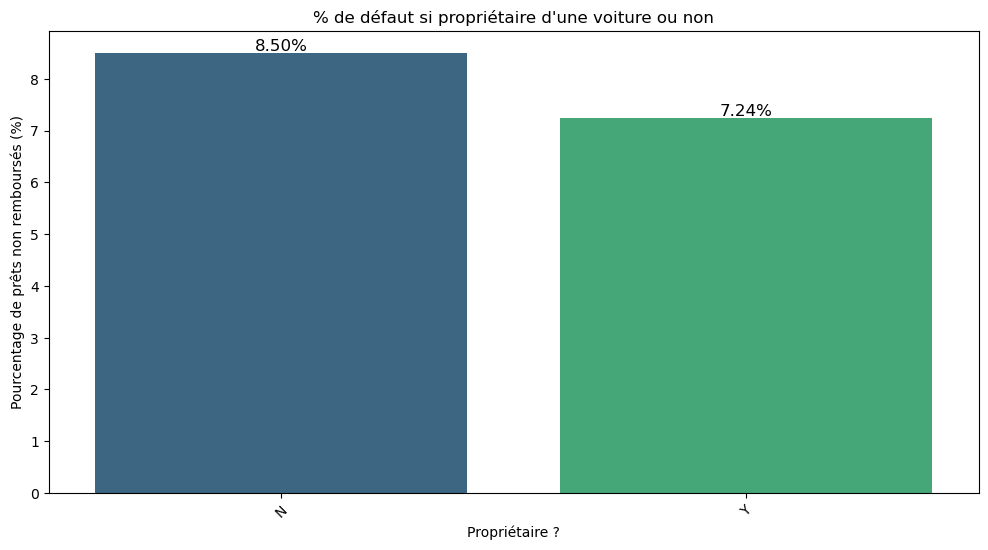

In [46]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = application_train.groupby('FLAG_OWN_CAR')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("% de défaut si propriétaire d'une voiture ou non")
plt.xlabel('Propriétaire ?')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

- **Propriétaires de voiture** : Une proportion significative des clients possèdent une voiture. Cela peut indiquer une certaine stabilité financière, car la possession d'un véhicule est souvent associée à un certain niveau de revenu disponible.
- **Non-propriétaires de voiture** : Ce groupe représente également une part importante des demandeurs. Ne pas posséder de voiture peut être le résultat de diverses raisons, telles que vivre dans des zones urbaines avec un accès facile aux transports publics ou avoir des priorités financières différentes.

**Taux de non-remboursement par statut de propriété de voiture**
- **Propriétaires de voiture** : Le taux de défault pour les propriétaires de voiture est d'environ 8%. Bien que la possession d'une voiture soit souvent perçue comme un signe de stabilité financière, cela ne semble pas réduire significativement le risque de défault par rapport aux non-propriétaires.
- **Non-propriétaires de voiture** : Ce groupe présente également un taux de défault d'environ 8%. Cela suggère que, dans ce contexte, la possession d'une voiture n'est pas un facteur déterminant majeur pour évaluer le risque de crédit.

### 2.1.2 - Analyses bivariées

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, poursuivons l'exploration des données. Une façon de comprendre les données est d'examiner les corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode `.corr` du dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles dans les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

- **.00-.19** : "très faible"
- **.20-.39** : "faible"
- **.40-.59** : "modéré"
- **.60-.79** : "fort"
- **.80-1.0** : "très fort"

In [47]:
# Trouvons les corrélations avec la variable TARGET
correlations = df_application_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

ValueError: could not convert string to float: 'Cash loans'

Analysons les résultats des corrélations entre les caractéristiques et la variable cible `TARGET` pour comprendre quelles variables semblent avoir le plus d'impact potentiel sur la probabilité de défaut de paiement. 

**Corrélations Positives**

Voici les caractéristiques qui montrent les plus fortes corrélations positives avec la cible (`TARGET`), c’est-à-dire celles qui augmentent légèrement la probabilité de défaut :

1. **DAYS_BIRTH (0.078239)** : L'âge du client a une corrélation positive avec la probabilité de défaut, bien que cette corrélation soit assez faible. En général, une augmentation de l'âge pourrait être associée à un risque légèrement plus élevé, mais d'autres facteurs doivent être considérés.

2. **DAYS_EMPLOYED (0.074958)** : Le nombre de jours depuis le début de l'emploi est positivement corrélé à la probabilité de défaut. Cela pourrait indiquer que des emplois plus récents sont associés à un risque légèrement plus élevé, mais la corrélation est faible.

3. **NAME_INCOME_TYPE_Working (0.057481)** : Les clients dont le type de revenu est "Travailleur" ont une corrélation légèrement positive avec la probabilité de défaut.

4. **REGION_RATING_CLIENT_W_CITY (0.060893)** et **REGION_RATING_CLIENT (0.058899)** : La notation de la région du client montre une faible corrélation positive, ce qui peut indiquer une légère relation entre la région et la probabilité de défaut.

**Corrélations Négatives**

Voici les caractéristiques qui montrent les plus fortes corrélations négatives avec la cible, c’est-à-dire celles qui sont associées à une probabilité plus faible de défaut :

1. **EXT_SOURCE_1 (-0.155317)**, **EXT_SOURCE_2 (-0.160472)**, **EXT_SOURCE_3 (-0.178919)** : Les variables `EXT_SOURCE` montrent une corrélation négative plus significative avec la cible. Ces variables externes, souvent des scores de crédit, sont généralement associées à un risque plus faible de défaut de paiement.

2. **AMT_GOODS_PRICE (-0.039645)** : Le montant des biens achetés a une faible corrélation négative avec la probabilité de défaut. Un montant plus élevé pourrait être associé à une probabilité légèrement plus faible de défaut, ce qui pourrait être lié à un pouvoir d'achat plus élevé ou à une meilleure gestion financière.

3. **NAME_EDUCATION_TYPE_Higher education (-0.056593)** : Le niveau d'éducation supérieur a une corrélation négative avec la probabilité de défaut, suggérant que les clients avec un niveau d'éducation plus élevé sont légèrement moins susceptibles de faire défaut.

<center><span style="font-size:18px; font-weight:bold;">Effet de l'âge sur le défault de paiement</span><center>

In [ ]:
# Trouvons la corrélation entre les jours positifs depuis la naissance et la TARGET
df_application_train['DAYS_BIRTH'] = abs(df_application_train['DAYS_BIRTH'])
df_application_train['DAYS_BIRTH'].corr(df_application_train['TARGET'])

La corrélation de **-0.078** entre l'âge (représenté par `DAYS_BIRTH`) et la variable cible `TARGET` indique une relation faible mais négative. Voici quelques interprétations et points à considérer pour comprendre cet effet :

1. **Relation Faible**:
   - Une corrélation de **-0.078** est relativement faible, ce qui suggère que l'âge du client a une influence limitée sur la probabilité de défaut de paiement. La relation est négative, ce qui signifie qu'en général, les clients plus âgés ont une probabilité légèrement plus faible de défaut, mais cette tendance est très faible.

2. **Absence de Relation Forte**:
   - Étant donné que la corrélation est faible, l'âge n'explique qu'une petite partie de la variation dans le défaut de paiement. Cela indique que d'autres facteurs peuvent être plus importants pour prédire le risque de défaut.

In [ ]:
# Transformons DAYS_BIRTH en années
df_application_train['AGE'] = -df_application_train['DAYS_BIRTH'] / -365

# Visualisons la distribution de l'âge par rapport à la TARGET
plt.figure(figsize=(12, 6))
sns.histplot(data=df_application_train, x='AGE', hue='TARGET', multiple='stack', bins=30)
plt.title('Distribution de l\'âge des clients par rapport à la TARGET')
plt.xlabel('Âge')
plt.ylabel('Nombre de clients')
plt.show()

La distribution de l'âge en faisant apparaître les défaults nous renseigne un peu sur nos individus, on peut également voir qu'il n'y a pas de valeurs aberrantes puisque tous les âges semblent raisonnables. Pour mieux visualiser l'effet de l'âge sur la cible, nous allons créer un graphique d'estimation de densité par noyau (KDE) coloré en fonction de la valeur de la cible. Un graphique d'estimation de densité par noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement gaussien, pour chaque point de données, puis en moyenne tous les noyaux individuels pour développer une courbe lisse unique). Nous utiliserons la fonction `kdeplot` de Seaborn pour ce graphique.

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot des crédits payés à temps
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot des crédits non payés à temps
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe pour **target == 1** tend vers les âges plus jeunes. Bien que la corrélation ne soit pas significative (-0,07 pour le coefficient de corrélation), cette variable est probablement utile dans un modèle d'apprentissage automatique car elle a un effet sur la cible. Examinons cette relation d'une autre manière : le taux de défaut de remboursement des prêts par tranche d'âge.

Pour créer ce graphique, nous allons d'abord diviser les âges en tranches de 5 ans. Ensuite, pour chaque tranche, nous calculerons la valeur moyenne de la cible, ce qui nous indiquera le ratio de prêts non remboursés dans chaque tranche d'âge.

In [ ]:
# Création d'un dataframe pour l'âge
age_data = df_application_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Création des tranches d'âge
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11), right=False)

# Affichage des premières lignes pour vérifier
print(age_data.head(10))

In [ ]:
# Calcul du taux de défaut pour chaque tranche d'âge
age_group_default_rate = age_data.groupby('YEARS_BINNED')['TARGET'].mean().reset_index()

# Affichage des taux de défaut par tranche d'âge
print(age_group_default_rate)

In [ ]:
plt.figure(figsize=(12, 6))

# Tracer le taux de défaut pour chaque tranche d'âge
plt.bar(age_group_default_rate['YEARS_BINNED'].astype(str), age_group_default_rate['TARGET'], color='skyblue')

# Ajouter les labels et le titre
plt.xlabel('Tranche d\'âge')
plt.ylabel('Taux de défaut')
plt.title('Taux de Défaut par Tranche d\'Âge')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()


Il y a une tendance claire : les jeunes sont plus susceptibles de ne pas rembourser le prêt ! Le taux de défaut de remboursement est supérieur à 10 % pour les trois tranches d'âge les plus jeunes et inférieur à 5 % pour la tranche d'âge la plus âgée.

Cette information pourrait être directement utilisée par la banque : étant donné que les clients plus jeunes sont moins susceptibles de rembourser le prêt, il serait peut-être judicieux de leur fournir davantage de conseils ou de recommandations en matière de gestion financière. Cela ne signifie pas que la banque devrait discriminer les jeunes clients, mais il serait prudent de prendre des mesures préventives pour aider les jeunes clients à payer à temps.

<center><span style="font-size:18px; font-weight:bold;">Les sources extérieures</span><center>

Pour examiner les variables avec les corrélations négatives les plus fortes par rapport à la cible, nous allons nous concentrer sur **EXT_SOURCE_1**, **EXT_SOURCE_2**, et **EXT_SOURCE_3**. Selon la documentation, ces caractéristiques représentent un "score normalisé provenant de sources de données externes". Bien que le sens exact ne soit pas clair, il pourrait s'agir d'une sorte de cote de crédit cumulative basée sur diverses sources de données.

In [ ]:
# Nous allons extraire les variables EXT_SOURCE
ext_data = df_application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
# Nous allons créer une Heatmap de corrélations
plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques **EXT_SOURCE** présentent des corrélations négatives avec la cible, ce qui indique que, à mesure que la valeur de **EXT_SOURCE** augmente, le client est plus susceptible de rembourser le prêt. De plus, **DAYS_BIRTH** est positivement corrélé avec **EXT_SOURCE_1**, ce qui suggère que l'âge du client pourrait être un facteur pris en compte dans ce score.

Pour mieux comprendre l'impact de ces variables sur la cible, nous pouvons examiner la distribution de chaque caractéristique **EXT_SOURCE**, colorée en fonction de la valeur de la cible. Cela permettra de visualiser l'effet de ces variables sur le remboursement des prêts.

In [ ]:
plt.figure(figsize = (10, 12))

# Itérons les différentes sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, source], label = 'target == 1')

    # Ajouter une légende
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

**EXT_SOURCE_3** montre la plus grande différence entre les valeurs de la cible. On peut clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un client rembourse un prêt. Bien que la relation ne soit pas très forte (en fait, elles sont toutes considérées comme très faibles), ces variables seront tout de même utiles pour un modèle d'apprentissage automatique visant à prédire si un client remboursera un prêt à temps.

In [ ]:
# Copier les données pour le tracé
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Ajouter l'âge du client en années
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Supprimer les valeurs manquantes et limiter aux 100000 premières lignes
plot_data = plot_data.dropna().iloc[:100000]

# Fonction pour calculer le coefficient de corrélation entre deux colonnes
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(f"r = {r:.2f}",
                xy=(0.2, 0.8), xycoords=ax.transAxes,
                size=20, ha='center')

# Créer l'objet PairGrid
grid = sns.PairGrid(data=plot_data, height=3, diag_sharey=False, hue='TARGET',
                    vars=[x for x in plot_data.columns if x != 'TARGET'])

# Tracer le nuage de points dans la partie supérieure
grid.map_upper(plt.scatter, alpha=0.2)

# Tracer l'histogramme dans la diagonale
grid.map_diag(sns.kdeplot)

# Tracer le graphique de densité dans la partie inférieure
grid.map_lower(sns.kdeplot, cmap='OrRd_r')

# Ajouter les coefficients de corrélation aux graphiques supérieurs
grid.map_upper(corr_func)

# Ajuster le titre global
plt.suptitle('Pair Plot of External Sources and Age Features', size=32, y=1.05)

plt.show()

Dans ce graphique, le rouge indique les prêts non remboursés et le bleu les prêts remboursés. Nous pouvons observer les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre **EXT_SOURCE_1** et **DAYS_BIRTH** (ou équivalemment **YEARS_BIRTH**), ce qui indique que cette caractéristique pourrait prendre en compte l'âge du client.

1. **Relation entre EXT_SOURCE_1 et l'Âge** :
   - La relation positive modérée suggère que les valeurs plus élevées de **EXT_SOURCE_1** sont associées à un âge plus élevé. Cela peut signifier que les scores externes incluent l'âge du client ou qu'ils sont influencés par des facteurs corrélés avec l'âge.

2. **Impact sur la Prédiction de Remboursement** :
   - Les caractéristiques comme **EXT_SOURCE_1** qui montrent une telle relation avec l'âge peuvent être particulièrement utiles pour les modèles de prédiction. Elles pourraient indiquer que les clients plus âgés, en général, ont de meilleures chances de rembourser leurs prêts.

3. **Visualisation des Relations** :
   - La séparation des prêts remboursés et non remboursés en utilisant les couleurs (bleu et rouge) permet de voir comment ces groupes se distribuent en fonction des caractéristiques. Par exemple, si les prêts non remboursés tendent à se regrouper à des valeurs plus faibles de **EXT_SOURCE_1** et à des âges plus jeunes, cela peut aider à comprendre quels facteurs sont associés au défaut de paiement.

## 2.2 - df_bureau

Ce fichier contient tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été déclarés au Bureau de crédit (pour les clients qui ont un prêt dans l'échantillon). Pour chaque prêt de l'échantillon, il y a autant de lignes que de nombre de crédits que le client avait au bureau de crédit avant la date de la demande. SK_ID_CURR est la clé reliant les données application_train | test aux données du bureau.

Il est nécessaire de fusionner "application_train" avec "bureau" pour pour pouvoir extraire la part de TARGET == 1.

In [ ]:
df_application_bureau_train = df_application_train.merge(df_bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [ ]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'CREDIT_ACTIVE'
title = "Clients propriétaire d'une voiture"

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=df_application_bureau_train, order=df_application_bureau_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(df_application_bureau_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

In [ ]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = df_application_bureau_train.groupby('CREDIT_ACTIVE')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("Pourcentage de prêts non remboursés (%) par type de contrat")
plt.xlabel('Type de contrat')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

In [ ]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'CREDIT_CURRENCY'
title = "Clients propriétaire d'une voiture"

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=df_application_bureau_train, order=df_application_bureau_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(df_application_bureau_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

In [ ]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = df_application_bureau_train.groupby('CREDIT_CURRENCY')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("Pourcentage de prêts non remboursés (%) par type de contrat")
plt.xlabel('Type de contrat')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

## 2.2 - df_previous_application

"previous_application" contient des informations sur toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans l'échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données. SK_ID_CURR est la clé reliant les données application_train | test aux données previous_application.

Il est nécessaire de fusionner "application_train" avec "previous_application" pour pour pouvoir extraire la part de TARGET == 1.

In [ ]:
df_application_previous_train = df_application_train.merge(df_previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [ ]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_CONTRACT_TYPE_y'
title = "Clients propriétaire d'une voiture"

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=df_application_previous_train, order=df_application_previous_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(df_application_previous_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

In [ ]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = df_application_previous_train.groupby('NAME_CONTRACT_TYPE_y')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("Pourcentage de prêts non remboursés (%) par type de contrat")
plt.xlabel('Type de contrat')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

In [ ]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_CONTRACT_STATUS'
title = "Clients propriétaire d'une voiture"

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=df_application_previous_train, order=df_application_previous_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(df_application_previous_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

In [ ]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = df_application_previous_train.groupby('NAME_CONTRACT_STATUS')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("Pourcentage de prêts non remboursés (%) par type de contrat")
plt.xlabel('Type de contrat')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

In [ ]:
# Spécifier la variable à analyser et le titre du graphique
feature = 'NAME_PAYMENT_TYPE'
title = "Clients propriétaire d'une voiture"

# Créer une figure et des axes pour le graphique
plt.figure(figsize=(20, 8))

# Créer un graphique en barres pour afficher la distribution des valeurs
ax = sns.countplot(y=feature, data=df_application_previous_train, order=df_application_previous_train[feature].value_counts(ascending=False).index, palette='viridis')

# Ajouter un titre au graphique
ax.set_title(title)

# Ajouter les annotations pour afficher les pourcentages sur le graphique
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / len(df_application_previous_train[feature]))
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()

In [ ]:
# Calcul du pourcentage de TARGET = 1 pour chaque niveau d'éducation
education_target_pct = df_application_previous_train.groupby('NAME_PAYMENT_TYPE')['TARGET'].mean() * 100

# Affichage du graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=education_target_pct.index, y=education_target_pct.values, palette='viridis')

# Ajout des pourcentages sur les barres
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center',
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                fontsize=12, 
                color='black')

# Labeling du graphique
plt.title("Pourcentage de prêts non remboursés (%) par type de contrat")
plt.xlabel('Type de contrat')
plt.ylabel('Pourcentage de prêts non remboursés (%)')
plt.xticks(rotation=45)  # Rotation des labels des axes x si nécessaire
plt.show()

# 3 - Création du df_final

Indispensable d'avoir une réflexion et une étape d'agrégation des données. Des informations complémentaires aux principaux fichiers peuvent en effet avoir un impact dans nos modélisations.

<center><span style="font-size:18px; font-weight:bold;">Création de df_data</span><center>

In [ ]:
# On va créer un premier dataframe en faisant un merge de df_application_train et df_application_test
df_data = pd.concat([df_application_train, df_application_test], ignore_index=False)

In [ ]:
print('Train:' + str(df_application_train.shape))
print('Test:' + str(df_application_test.shape))
print('>>> Data:' + str(df_data.shape))

Les deux jeux de données ont exactement le même format avec une seule différence, la TARGET dispo dans le train.

In [ ]:
# Vérifions nos valeurs manquantes de TARGET dans notre df_final
print('TEST de df_final : ' + str(df_data.TARGET.isna().sum()))

# Puis le nombre de ligne dans notre dataframe de TEST
print('TEST de df_application_test : ' + str(sum(df_data.SK_ID_CURR[df_data.TARGET.isna()] == df_application_test.SK_ID_CURR)))

# On vérifie si on est ok 
print(str('Notre merge est-il correct ? : ' + str(sum(df_data.SK_ID_CURR.isin(df_application_test.SK_ID_CURR)) == len(df_application_test))))

Avant de fusionner les données avec **bureau**, nous devons fusionner le DataFrame **bureau** avec les informations correspondantes dans le fichier **bureau_balance**.

Pourquoi devons nous faire ça ?

Le DataFrame **bureau** provient de l'autorité de crédit et affiche une ligne pour chaque crédit du client dans les données de **train/test**. Il est associé à **train/test** par `SK_ID_CURR`, et dans **train/test** nous n'avons pas de doublons pour `SK_ID_CURR`, dans la plupart des cas, le DataFrame **bureau** a plusieurs indices pour le même client, car celui-ci a demandé plusieurs prêts auparavant.

À son tour, **bureau_balance** nous donne encore plus d'informations sur les crédits précédents. Il contient une ligne distincte pour chaque mois de l'historique de chaque crédit précédent signalé au Bureau de Crédit (**df_bureau**) et est lié à **bureau** via `SK_ID_BUREAU`.

Ainsi, l'approche que nous allons utiliser consiste à calculer la moyenne de chaque colonne statistique de ces deux DataFrames pour inclure ces valeurs moyennes comme caractéristiques de nos clients que nous essayons de classifier. Par exemple : le nombre moyen de jours de retard pour tous les crédits que le client a pris précédemment.

Cette approche laisse de côté certaines informations, comme les colonnes catégorielles dans certains cas. Par exemple, le client avec *SK_ID_CURR = 666* avait 7 crédits dans le DataFrame **bureau**, et lorsque nous regroupons tous ces crédits (groupés par un seul ID) en une seule ligne pour indiquer les valeurs moyennes pour ces crédits, nous ne pourrons pas montrer une colonne `CREDIT_ACTIVE` qui a différentes valeurs catégorielles comme *Closed* ou *Active* pour différents crédits précédents. Cela laisse donc place à un peu de features engineering.

Les étapes que nous devons suivre :

1. Regrouper le DataFrame **bureau_balance** en valeurs moyennes par `SK_ID_BUREAU`.
2. Fusionner avec le DataFrame **bureau**.
3. Regrouper le DataFrame **bureau** en valeurs moyennes par `SK_ID_CURR`.
4. Fusionner ce que nous avons obtenu avec notre DataFrame **df_data**.
5. Bien que nous ayons décidé de ne pas effectuer de features enginnering, une variable utile s'impose d'elle-même. Calculons le nombre total de crédits précédents pris par chaque client et incluons-le dans nos statistiques.

In [ ]:
previous_loan_counts = df_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

In [ ]:
df_data = df_data.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

<center><span style="font-size:18px; font-weight:bold;">Jointure de df_bureau_balance</span><center>

<span style="font-size:14px; font-weight:bold;">STEP 1 - collapse bureau_balance</span>

In [ ]:
df_bureau_balance.head()

In [ ]:
def extract_mean(x):
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = x.select_dtypes(include=[np.number]).columns
    y = x[numeric_cols].groupby(x['SK_ID_BUREAU'], as_index=False).mean().add_prefix('BUR_BAL_MEAN_') 
    return y

In [ ]:
# apply formula to create bureau_balance dataframe grouped by SK_ID_BUREAU with mean values of all numerical columns
bureau_bal_mean = extract_mean(df_bureau_balance)
bureau_bal_mean.head()

Comme vous pouvez le voir, ce DataFrame n'inclut pas la colonne catégorielle STATUS du fichier bureau_balance.

Notez également que notre formule a modifié le nom de SK_ID_BUREAU, nous devons le remettre comme avant pour l'utiliser lors de la fusion avec le DataFrame bureau.

In [ ]:
bureau_bal_mean = bureau_bal_mean.rename(columns = {'BUR_BAL_MEAN_SK_ID_BUREAU' : 'SK_ID_BUREAU'})

<span style="font-size:14px; font-weight:bold;">STEP 2 - merge bureau_balance</span>

In [ ]:
bureau = df_bureau.merge(bureau_bal_mean, on = 'SK_ID_BUREAU', how = 'left')
bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True) # we don't need this internal ID anymore

<span style="font-size:14px; font-weight:bold;">STEP 3 - collapse bureau</span>

In [ ]:
def extract_mean(x):
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = x.select_dtypes(include='number')
    # Appliquer la moyenne seulement sur les colonnes numériques
    y = numeric_cols.groupby(x['SK_ID_CURR'], as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
    return y

In [ ]:
bureau.head()

In [ ]:
bureau.info()

In [ ]:
bureau_mean_values = extract_mean(bureau)
bureau_mean_values = bureau_mean_values.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean_values.head(5)

Looks good. There are a few missing values although which we will deal with later

<span style="font-size:14px; font-weight:bold;">STEP 4 - merge bureau avec df_data</span>

In [ ]:
df_data.shape

In [ ]:
df_data = df_data.merge(bureau_mean_values, on = 'SK_ID_CURR', how = 'left')

In [ ]:
df_data.shape

So here we've created 13 new features and added them to our train/test dataset called 'data'

<center><span style="font-size:18px; font-weight:bold;">Jointure de df_previous_application</span><center>

Informations rapides sur ce bloc de données : étonnamment... `previous_application` reflète les demandes de prêt précédentes des clients auprès de Home Credit. Comme précédemment, `previous_application` se décompose en une multitude de statistiques avec trois autres DataFrames :

- `POS_CASH_balance` : instantanés mensuels des soldes des précédents points de vente et prêts en espèces que le demandeur a eus avec Home Credit (une ligne pour chaque mois d'historique)
- `installments_payments` : historique des remboursements des crédits précédents avec Home Credit (une ligne pour chaque paiement)
- `credit_card_balance` : instantanés mensuels des soldes des cartes de crédit du demandeur (une ligne pour chaque mois d'historique)

Ces 4 jeux de données ont leur propre clé pour le mappage interne - `SK_ID_PREV`.

Le plan ici serait le suivant :

1. Réduire le DataFrame `credit_card_balance` à des valeurs moyennes groupées par `SK_ID_PREV`.
2. Fusionner avec `previous_application` (notre dataset principal dans ce cas).
3. Réduire `POS_CASH_balance` à des valeurs moyennes groupées par `SK_ID_PREV`.
4. Fusionner avec `previous_application`.
5. Réduire `installments_payments`...
6. Fusionner avec `previous_application`.
7. Réduire le dataset résultant `previous_application` à des valeurs moyennes groupées par `SK_ID_CURR`.
8. Fusionner nos statistiques déployées de `previous_application` avec nos données.

Mais avant de commencer, vérifions s'il y a des enregistrements dans `previous_application` qui ne sont pas dans nos données."

In [ ]:
len(df_previous_application.SK_ID_CURR.isin(df_data.SK_ID_CURR)) == len(df_previous_application)

Encore une chose ! Nous allons supprimer la colonne `SK_ID_CURR` des DataFrames `credit_card_balance`, `POS_CASH_balance` et `installment_payments` car nous n'avons pas besoin que cette colonne soit incluse dans les moyennes. Cette information n'a aucun impact sur les statistiques et ne ferait que surcharger l'espace en ajoutant du bruit. Nous allons les regrouper avec notre dataset principal `previous_application` en utilisant `SK_ID_PREV`, et notre dataset principal contient cette clé `SK_ID_CURR` qui sera ensuite utilisée pour faire le lien avec nos données.

In [ ]:
df_credit_card_balance.drop('SK_ID_CURR', axis = 1, inplace = True)
df_installments_payments.drop('SK_ID_CURR', axis = 1, inplace = True)
df_POS_CASH_balance.drop('SK_ID_CURR', axis = 1, inplace = True)

Comme précédemment, avant de déconstruire les statistiques des `previous_applications` (demandes précédentes) chez Home Credit, extrayons le nombre de demandes précédentes effectuées par les clients auprès de Home Credit et ajoutons cette caractéristique à nos données.

In [ ]:
previous_application_counts = df_previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

In [ ]:
# and throw that column in our data
df_data = df_data.merge(previous_application_counts, on = 'SK_ID_CURR', how = 'left')
df_data.head()

<span style="font-size:14px; font-weight:bold;">STEP 1 - collapse credit_card_balance</span>

In [ ]:
def extract_mean(x):
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = x.select_dtypes(include='number').copy()
    
    # Ajouter SK_ID_PREV pour pouvoir regrouper
    numeric_cols['SK_ID_PREV'] = x['SK_ID_PREV']
    
    # Appliquer le groupby et la moyenne
    y = numeric_cols.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
    
    # Retirer le préfixe ajouté à SK_ID_PREV
    y = y.rename(columns={'CARD_MEAN_SK_ID_PREV': 'SK_ID_PREV'})
    
    return y

credit_card_balance_mean = extract_mean(df_credit_card_balance)

<span style="font-size:14px; font-weight:bold;">STEP 2 - merge avec previous_application</span>

In [ ]:
previous_application = df_previous_application.merge(credit_card_balance_mean, on = 'SK_ID_PREV', how = 'left')

<span style="font-size:14px; font-weight:bold;">STEP 3 - collapse installments_payments</span>

In [ ]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
    return y

install_pay_mean = extract_mean(df_installments_payments)

install_pay_mean = install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'})

<span style="font-size:14px; font-weight:bold;">STEP 4 - merge avec df_previous_application</span>

In [ ]:
previous_application = previous_application.merge(install_pay_mean, on = 'SK_ID_PREV', how = 'left')

<span style="font-size:14px; font-weight:bold;">STEP 5 - collapse POS_CASH_balance</span>

In [ ]:
def extract_mean(x):
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = x.select_dtypes(include='number').copy()

    # Ajouter SK_ID_PREV pour pouvoir regrouper
    numeric_cols['SK_ID_PREV'] = x['SK_ID_PREV']

    # Appliquer le groupby et la moyenne uniquement sur les colonnes numériques
    y = numeric_cols.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')

    # Renommer la colonne de clé primaire
    y = y.rename(columns={'POS_MEAN_SK_ID_PREV': 'SK_ID_PREV'})
    
    return y

POS_mean = extract_mean(df_POS_CASH_balance)

<span style="font-size:14px; font-weight:bold;">STEP 6 - merge avec df_previous_application</span>

In [ ]:
previous_application = previous_application.merge(POS_mean, on = 'SK_ID_PREV', how = 'left')

<span style="font-size:14px; font-weight:bold;">STEP 7 - collapse previous_application</span>

In [ ]:
def extract_mean(x):
    # Select only the numeric columns
    numeric_columns = x.select_dtypes(include=[np.number])
    
    # Group by 'SK_ID_CURR' and compute the mean of the numeric columns
    y = numeric_columns.groupby(x['SK_ID_CURR'], as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
    
    return y

prev_appl_mean = extract_mean(previous_application)

# Rename the column back to 'SK_ID_CURR'
prev_appl_mean = prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})

# If there's a need to drop certain columns, do it here
# prev_appl_mean = prev_appl_mean.drop('column_name', axis = 1)

<span style="font-size:14px; font-weight:bold;">STEP 8 - merge pour obtenir notre df_final</span>

In [ ]:
print('data shape', df_data.shape)
print('previous applications statistics shape', prev_appl_mean.shape)

In [ ]:
df_final = df_data.merge(prev_appl_mean, on = 'SK_ID_CURR', how = 'left')

In [ ]:
df_final.info()

# 4 - Features engineering

In [ ]:
df_final.head()